In [1]:
import pandas as pd
import seaborn as sns 
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt 
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.arima.model import ARIMA
import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

# EDA on Industry Dataset

## Dataset Overview

In [2]:
df = pd.read_csv("industry - industry.csv")
df.head()

timestamp  machines  pressure
0  2023-06-01 15:00:00      4948      1426
1  2023-06-01 15:00:02     14031         9
2  2023-06-01 15:00:04         1      1389
3  2023-06-01 15:00:06        13      1004
4  2023-06-01 15:00:09         8       779

In [3]:
df.tail()

timestamp  machines  pressure
4995  2023-06-01 17:59:51         2       722
4996  2023-06-01 17:59:54         3      1322
4997  2023-06-01 17:59:56         8       696
4998  2023-06-01 17:59:58       688   3775428
4999  2023-06-01 18:00:00        10   3967339

In [4]:
stats = df.describe()
stats

machines      pressure
count   5000.000000  5.000000e+03
mean     802.933200  7.748895e+05
std     2789.412281  2.688270e+06
min        1.000000  0.000000e+00
25%        4.000000  4.147500e+02
50%        8.000000  8.315000e+02
75%       12.000000  1.248000e+03
max    16135.000000  1.477435e+07

In [5]:
#calculate range, and move columns 25%,50%,75%  and mean values into a dataframe
stats.loc['range'] = stats.loc['max'] - stats.loc['min']
new_df = stats.loc[['mean', 'range', '25%', '50%', '75%']]
new_df.rename({'50%': 'median'}, inplace=True)
new_df

machines      pressure
mean      802.9332  7.748895e+05
range   16134.0000  1.477435e+07
25%         4.0000  4.147500e+02
median      8.0000  8.315000e+02
75%        12.0000  1.248000e+03

In [6]:
df.shape

(5000, 3)

In [7]:
df.info

<bound method DataFrame.info of                 timestamp  machines  pressure
0     2023-06-01 15:00:00      4948      1426
1     2023-06-01 15:00:02     14031         9
2     2023-06-01 15:00:04         1      1389
3     2023-06-01 15:00:06        13      1004
4     2023-06-01 15:00:09         8       779
...                   ...       ...       ...
4995  2023-06-01 17:59:51         2       722
4996  2023-06-01 17:59:54         3      1322
4997  2023-06-01 17:59:56         8       696
4998  2023-06-01 17:59:58       688   3775428
4999  2023-06-01 18:00:00        10   3967339

[5000 rows x 3 columns]>

## Check for duplication

In [8]:
df.nunique()

timestamp    5000
machines      508
pressure     1925
dtype: int64

## Checking missing values

In [9]:
df.isnull().sum()

timestamp    0
machines     0
pressure     0
dtype: int64

## Isolation Forest

In [10]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

In [11]:
# Feature engineering
df['machine_diff'] = df['machines'].diff().fillna(0)
df['pressure_diff'] = df['pressure'].diff().fillna(0)
df['machine_rolling_mean'] = df['machines'].rolling(window=10).mean().fillna(0)
df['pressure_rolling_mean'] = df['pressure'].rolling(window=10).mean().fillna(0)

In [12]:
# Select features for anomaly detection
features = ['machines', 'pressure', 'machine_diff', 'pressure_diff', 'machine_rolling_mean', 'pressure_rolling_mean']
X = df[features]


In [13]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
# Train Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso_forest.fit_predict(X_scaled)


In [15]:
# Map anomaly labels to 0 and 1 (1 for anomaly)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})

In [16]:
# Print the number of detected anomalies
print("Number of detected anomalies (intensifications):")
print(df['anomaly'].sum())

Number of detected anomalies (intensifications):
50


In [17]:
# Print the first few rows of the dataframe with anomaly labels
print("Dataframe with anomaly labels head:")
print(df.head())

Dataframe with anomaly labels head:
                     machines  pressure  machine_diff  pressure_diff  \
timestamp                                                              
2023-06-01 15:00:00      4948      1426           0.0            0.0   
2023-06-01 15:00:02     14031         9        9083.0        -1417.0   
2023-06-01 15:00:04         1      1389      -14030.0         1380.0   
2023-06-01 15:00:06        13      1004          12.0         -385.0   
2023-06-01 15:00:09         8       779          -5.0         -225.0   

                     machine_rolling_mean  pressure_rolling_mean  anomaly  
timestamp                                                                  
2023-06-01 15:00:00                   0.0                    0.0        0  
2023-06-01 15:00:02                   0.0                    0.0        0  
2023-06-01 15:00:04                   0.0                    0.0        0  
2023-06-01 15:00:06                   0.0                    0.0        0  
202

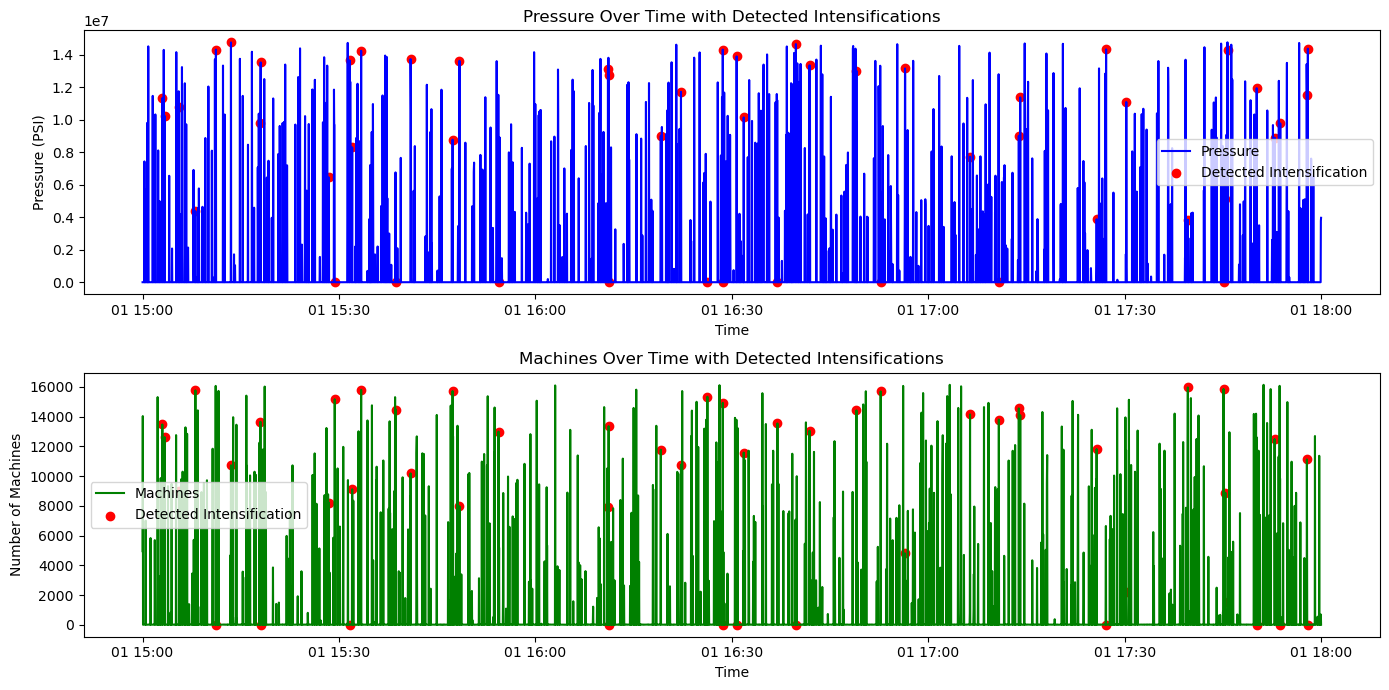

In [18]:
# Plot the results
plt.figure(figsize=(14, 7))

# Plot pressure
plt.subplot(2, 1, 1)
plt.plot(df.index, df['pressure'], label='Pressure', color='blue')
plt.scatter(df.index[df['anomaly'] == 1], 
            df['pressure'][df['anomaly'] == 1], 
            color='red', label='Detected Intensification', marker='o')
plt.title('Pressure Over Time with Detected Intensifications')
plt.xlabel('Time')
plt.ylabel('Pressure (PSI)')
plt.legend()

# Plot number of machines
plt.subplot(2, 1, 2)
plt.plot(df.index, df['machines'], label='Machines', color='green')
plt.scatter(df.index[df['anomaly'] == 1], 
            df['machines'][df['anomaly'] == 1], 
            color='red', label='Detected Intensification', marker='o')
plt.title('Machines Over Time with Detected Intensifications')
plt.xlabel('Time')
plt.ylabel('Number of Machines')
plt.legend()

plt.tight_layout()
plt.show()


# Time Series

In [19]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib import dates
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [20]:
df = pd.read_csv('industry - industry.csv', index_col = 'timestamp',parse_dates=True)
df

machines  pressure
timestamp                              
2023-06-01 15:00:00      4948      1426
2023-06-01 15:00:02     14031         9
2023-06-01 15:00:04         1      1389
2023-06-01 15:00:06        13      1004
2023-06-01 15:00:09         8       779
...                       ...       ...
2023-06-01 17:59:51         2       722
2023-06-01 17:59:54         3      1322
2023-06-01 17:59:56         8       696
2023-06-01 17:59:58       688   3775428
2023-06-01 18:00:00        10   3967339

[5000 rows x 2 columns]

In [21]:
df.index

DatetimeIndex(['2023-06-01 15:00:00', '2023-06-01 15:00:02',
               '2023-06-01 15:00:04', '2023-06-01 15:00:06',
               '2023-06-01 15:00:09', '2023-06-01 15:00:11',
               '2023-06-01 15:00:13', '2023-06-01 15:00:15',
               '2023-06-01 15:00:17', '2023-06-01 15:00:19',
               ...
               '2023-06-01 17:59:41', '2023-06-01 17:59:43',
               '2023-06-01 17:59:45', '2023-06-01 17:59:47',
               '2023-06-01 17:59:49', '2023-06-01 17:59:51',
               '2023-06-01 17:59:54', '2023-06-01 17:59:56',
               '2023-06-01 17:59:58', '2023-06-01 18:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=5000, freq=None)

In [22]:
df.isnull().sum()

machines    0
pressure    0
dtype: int64

In [23]:
df.head()

machines  pressure
timestamp                              
2023-06-01 15:00:00      4948      1426
2023-06-01 15:00:02     14031         9
2023-06-01 15:00:04         1      1389
2023-06-01 15:00:06        13      1004
2023-06-01 15:00:09         8       779

In [24]:
df.tail()

machines  pressure
timestamp                              
2023-06-01 17:59:51         2       722
2023-06-01 17:59:54         3      1322
2023-06-01 17:59:56         8       696
2023-06-01 17:59:58       688   3775428
2023-06-01 18:00:00        10   3967339

## Time Shifting

In [25]:
df.shift(1).head()

machines  pressure
timestamp                              
2023-06-01 15:00:00       NaN       NaN
2023-06-01 15:00:02    4948.0    1426.0
2023-06-01 15:00:04   14031.0       9.0
2023-06-01 15:00:06       1.0    1389.0
2023-06-01 15:00:09      13.0    1004.0

In [26]:
df.shift(1).tail()

machines   pressure
timestamp                               
2023-06-01 17:59:51      14.0     1320.0
2023-06-01 17:59:54       2.0      722.0
2023-06-01 17:59:56       3.0     1322.0
2023-06-01 17:59:58       8.0      696.0
2023-06-01 18:00:00     688.0  3775428.0

In [27]:
df.shift(-1).tail()

machines   pressure
timestamp                               
2023-06-01 17:59:51       3.0     1322.0
2023-06-01 17:59:54       8.0      696.0
2023-06-01 17:59:56     688.0  3775428.0
2023-06-01 17:59:58      10.0  3967339.0
2023-06-01 18:00:00       NaN        NaN

In [28]:
df.shift(periods = 1,freq='M').head()

machines  pressure
timestamp                              
2023-06-30 15:00:00      4948      1426
2023-06-30 15:00:02     14031         9
2023-06-30 15:00:04         1      1389
2023-06-30 15:00:06        13      1004
2023-06-30 15:00:09         8       779

## Visualization

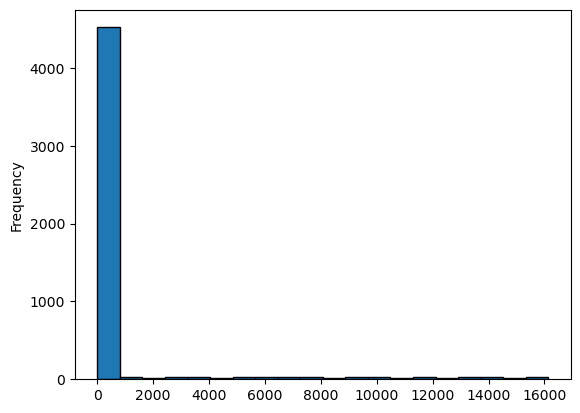

In [29]:
df['machines'].plot.hist(bins=20,edgecolor='k').autoscale(enable=True,axis='both')

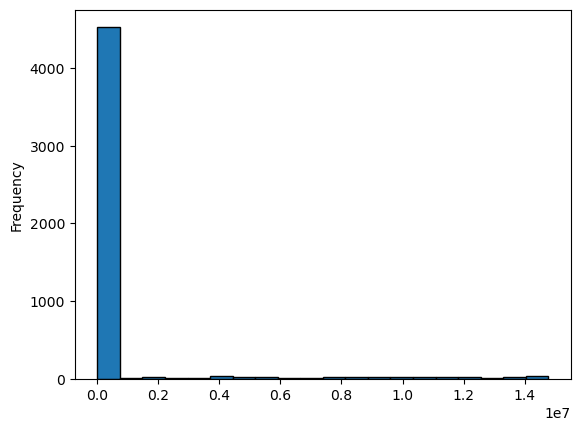

In [30]:
df['pressure'].plot.hist(bins=20,edgecolor='k').autoscale(enable=True,axis='both')

<Axes: ylabel='Frequency'>

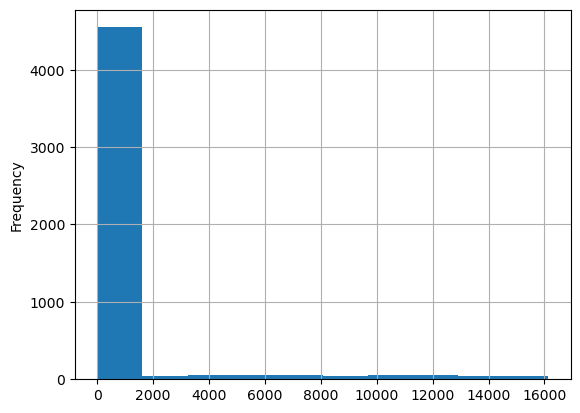

In [31]:
df['machines'].plot.hist(grid = True)

<Axes: ylabel='Frequency'>

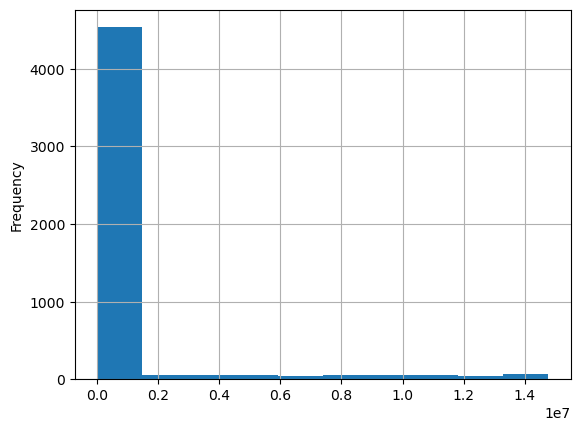

In [32]:
df['pressure'].plot.hist(grid = True)

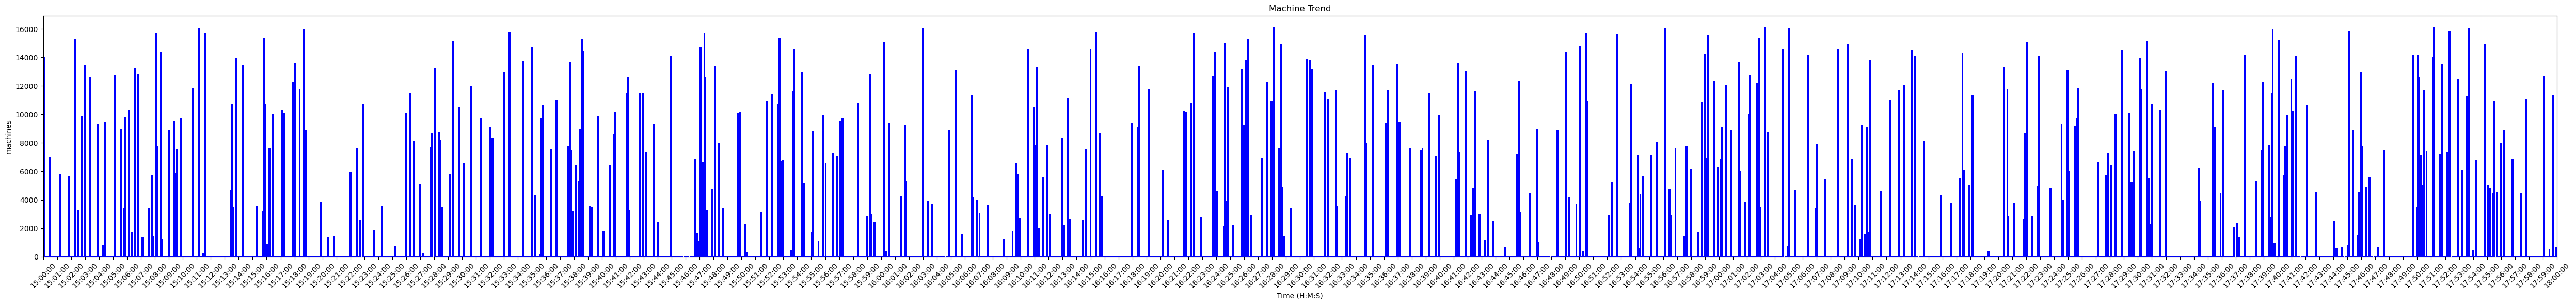

In [33]:
# Create bar plot
plt.figure(figsize=(50, 6))
plt.bar(df.index, df['machines'], width=0.0001, color='blue')

# Format the x-axis to show hours, minutes, and seconds
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))  # Show labels every minute
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Format the labels to show hours, minutes, and seconds

# Set x-axis limits to the range of the data
plt.xlim(df.index.min(), df.index.max())

plt.xlabel('Time (H:M:S)')
plt.ylabel('machines')
plt.title('Machine Trend')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

plt.show()

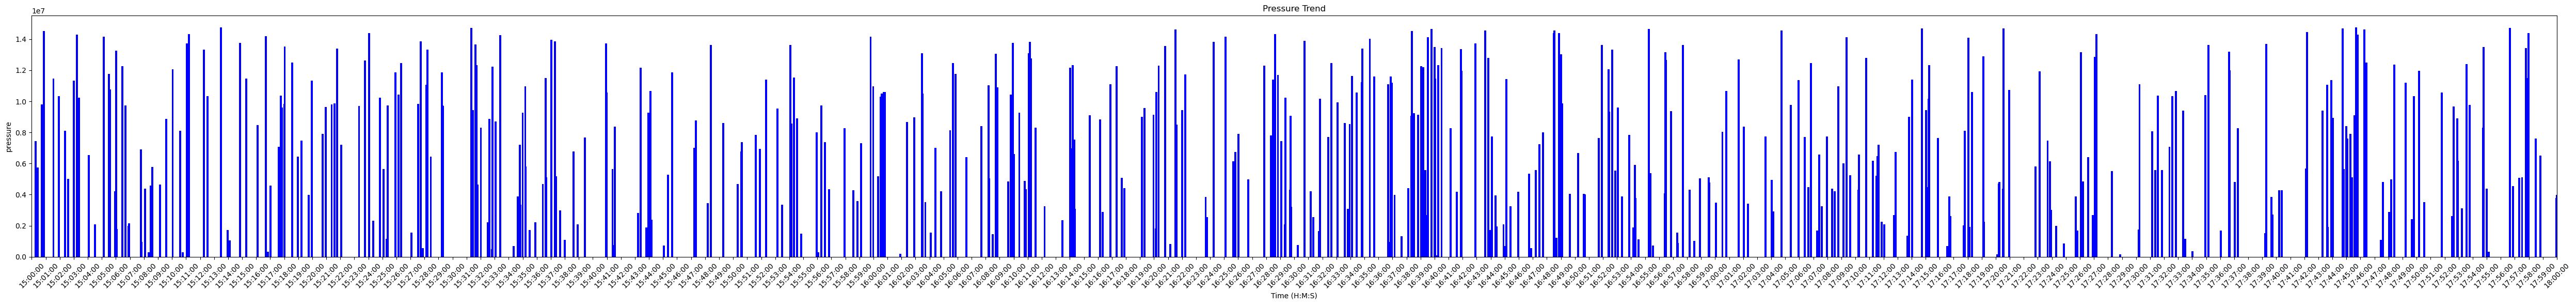

In [34]:
# Create bar plot
plt.figure(figsize=(50, 6))
plt.bar(df.index, df['pressure'], width=0.0001, color='blue')

# Format the x-axis to show hours, minutes, and seconds
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))  # Show labels every minute
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Format the labels to show hours, minutes, and seconds

# Set x-axis limits to the range of the data
plt.xlim(df.index.min(), df.index.max())

plt.xlabel('Time (H:M:S)')
plt.ylabel('pressure')
plt.title('Pressure Trend')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

plt.show()

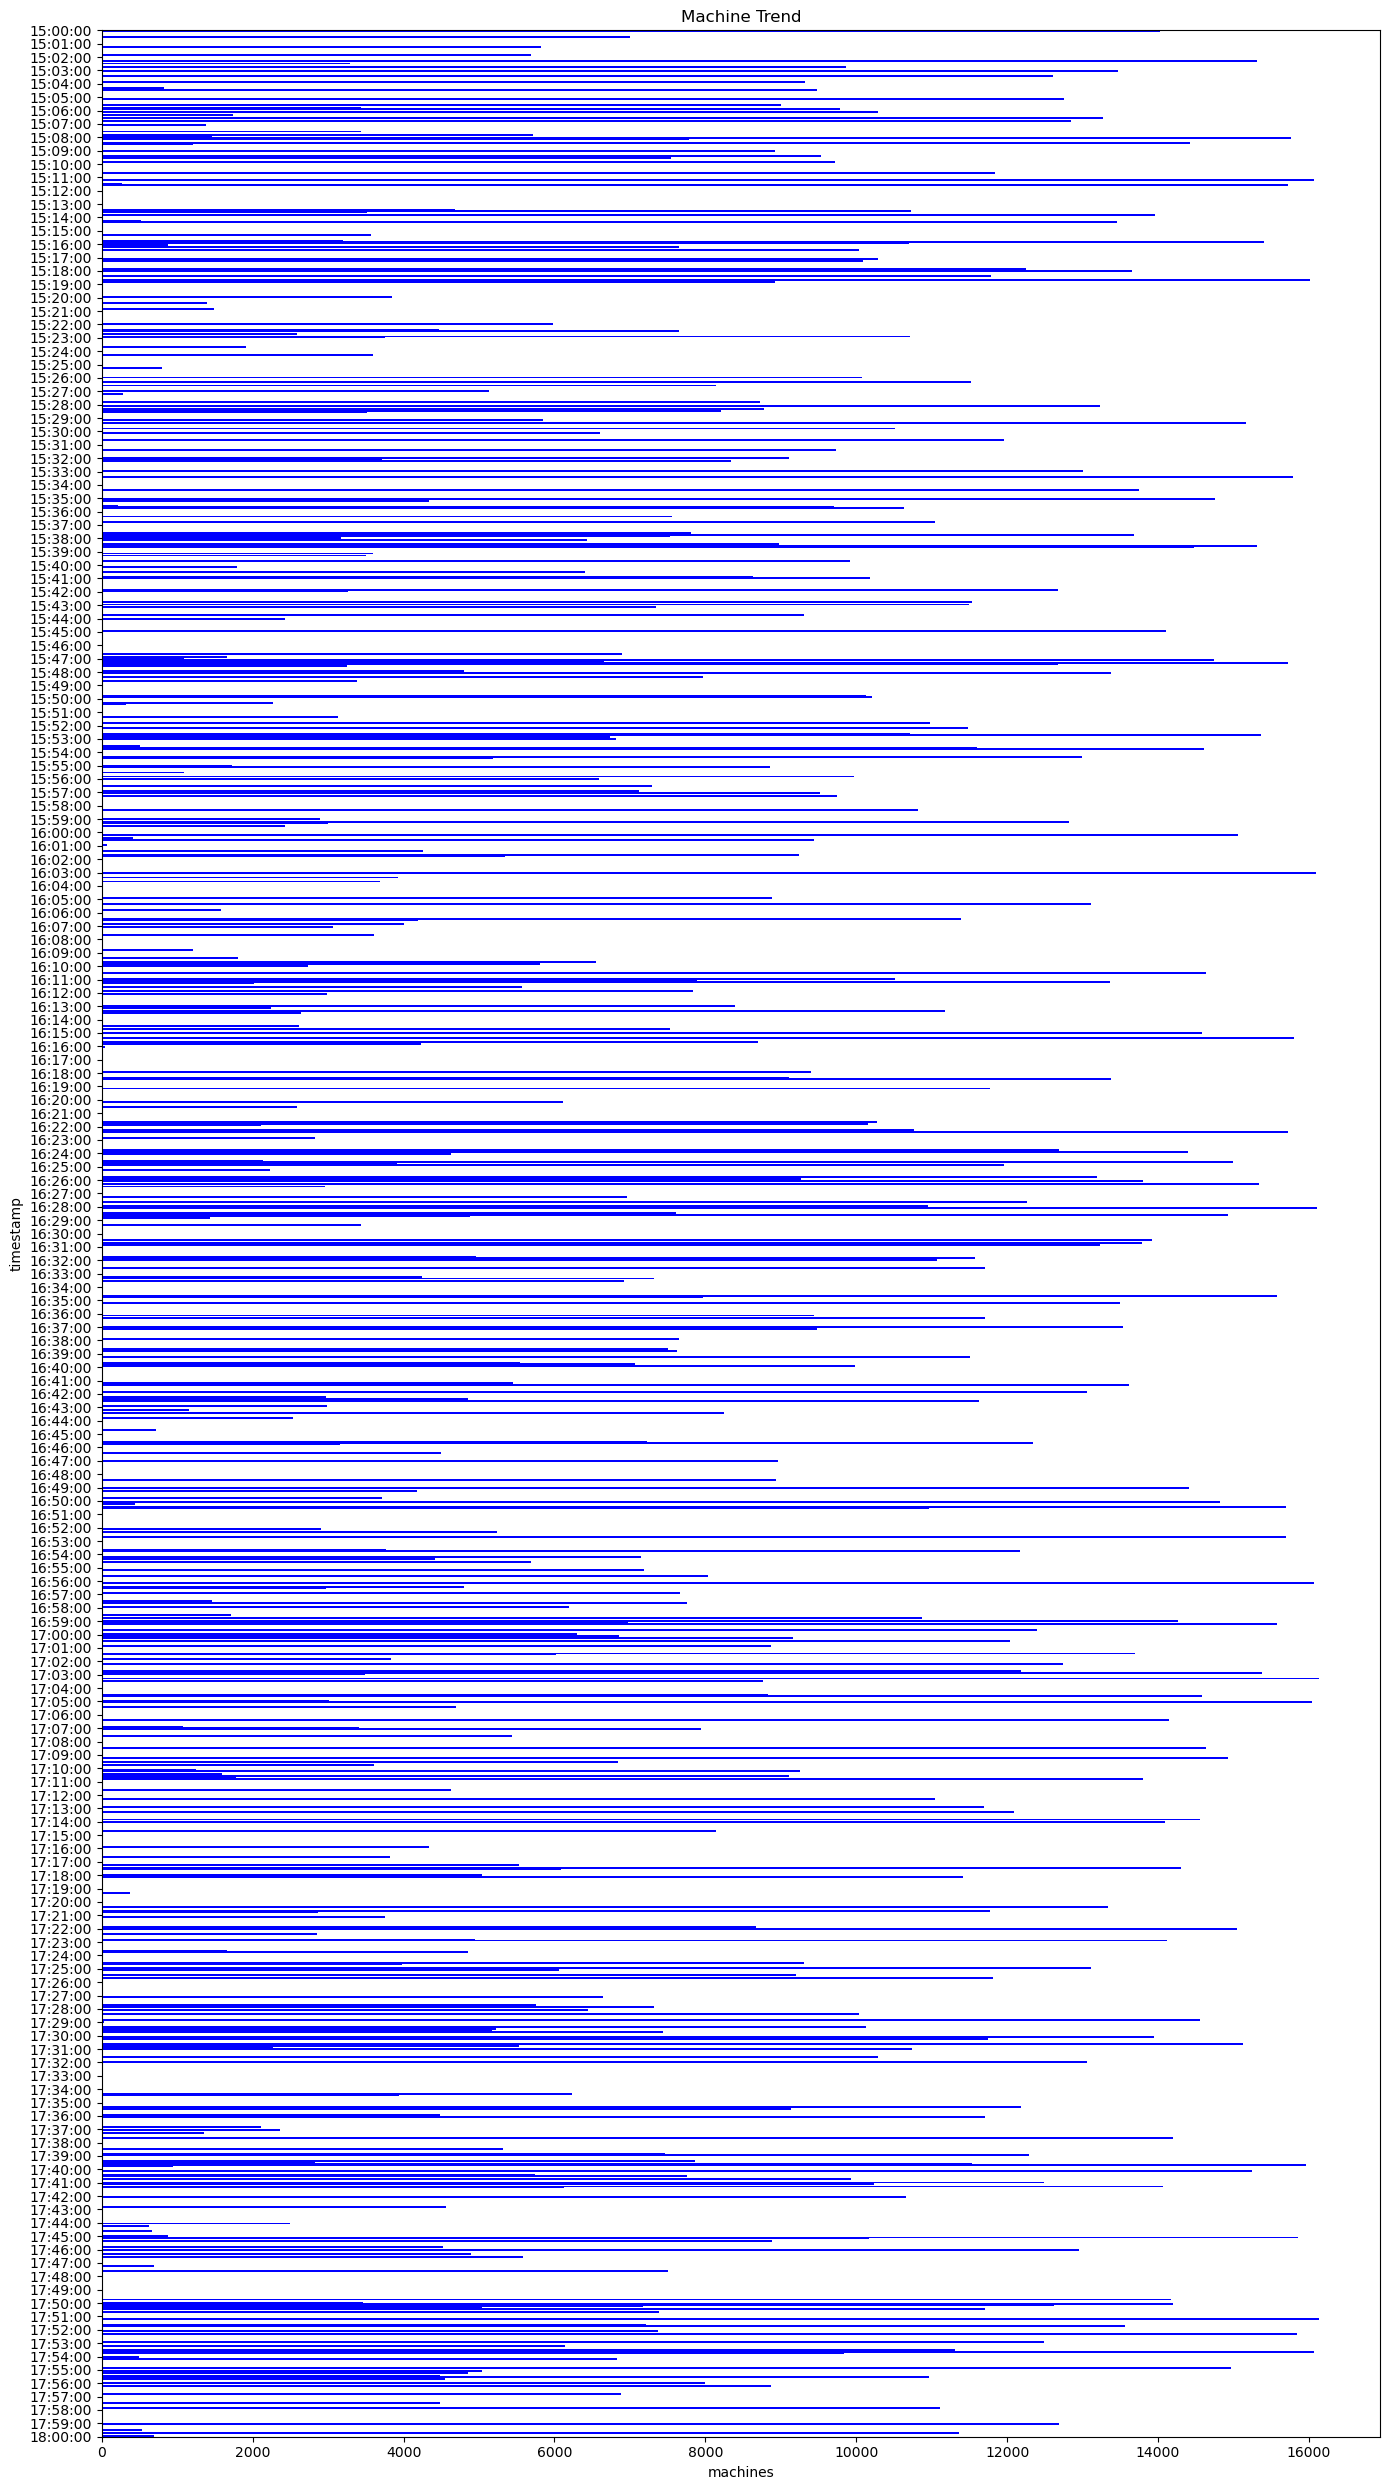

In [35]:
plt.figure(figsize=(14, 25))  # Increased figure size for better readability
plt.barh(df.index, df['machines'], color='blue', height=0.0001)  # Adjusted bar height for better visualization

# Format the y-axis to show minutes and seconds
plt.gca().yaxis.set_major_locator(mdates.MinuteLocator(interval=1))  # Show labels every minute
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Format the labels to show hours, minutes, and seconds

# Set y-axis limits to the range of the data
plt.ylim(df.index.min(), df.index.max())

plt.ylabel('timestamp')
plt.xlabel('machines')
plt.title('Machine Trend')
plt.gca().invert_yaxis()  # To display the earliest date at the top
plt.tight_layout()

plt.show()


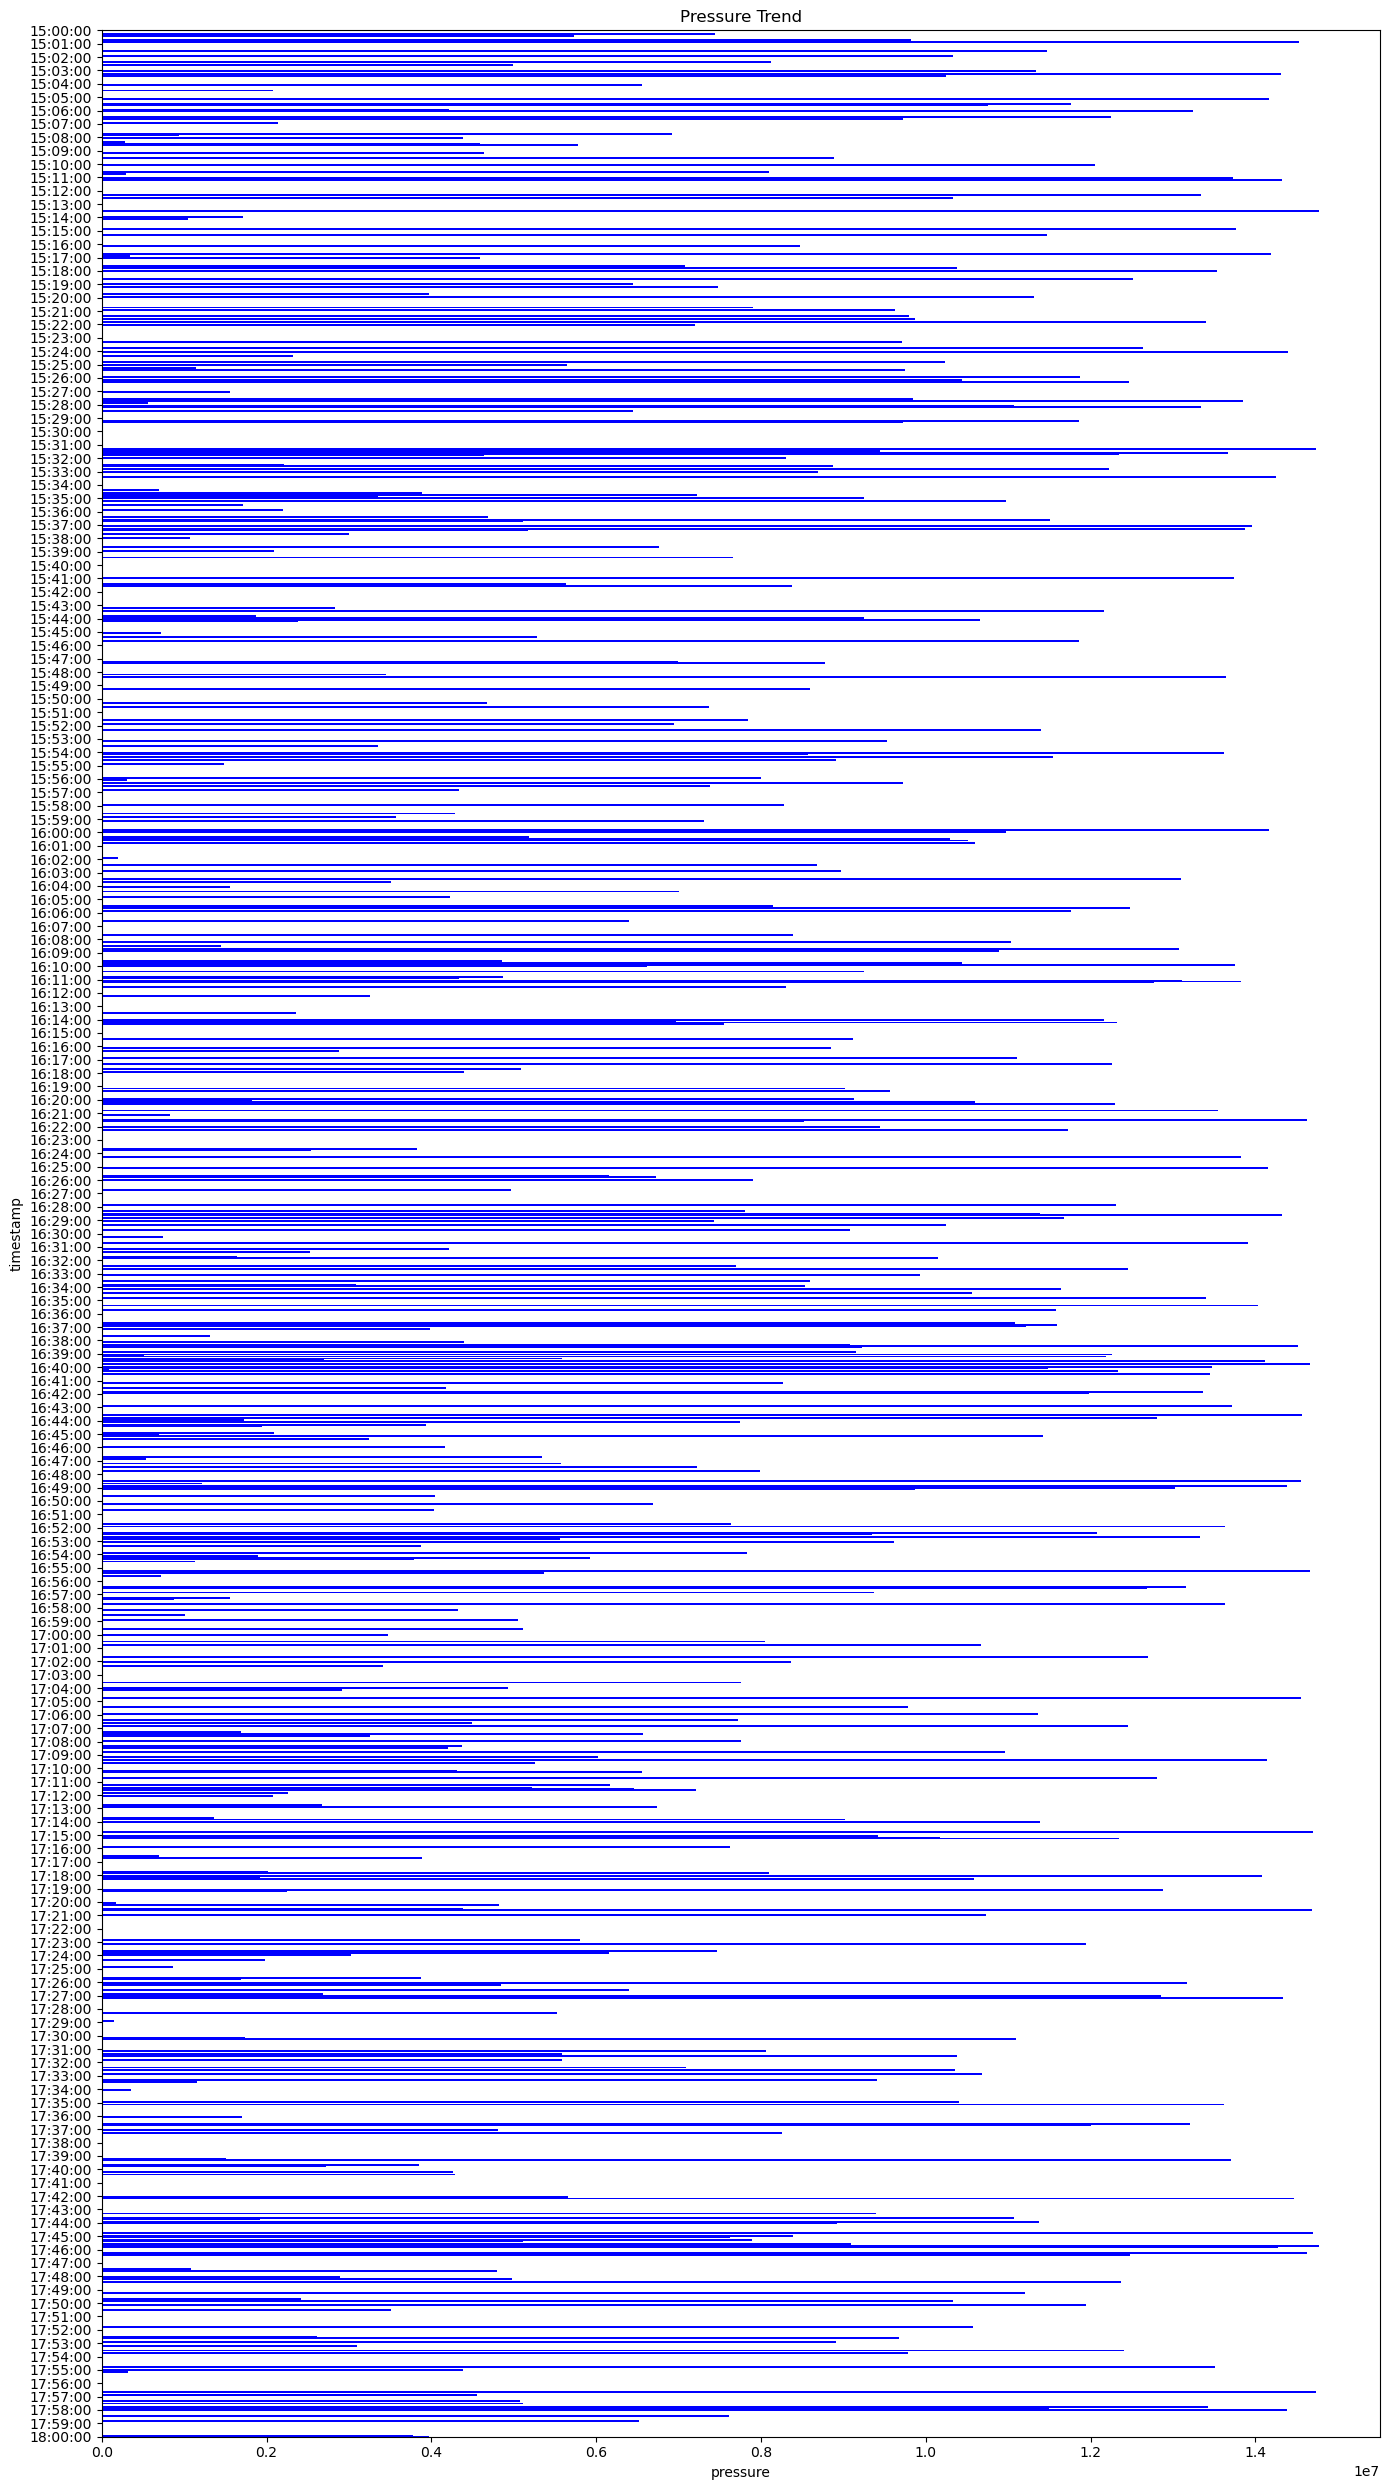

In [36]:
plt.figure(figsize=(14, 25))  # Increased figure size for better readability
plt.barh(df.index, df['pressure'], color='blue', height=0.0001)  # Adjusted bar height for better visualization

# Format the y-axis to show minutes and seconds
plt.gca().yaxis.set_major_locator(mdates.MinuteLocator(interval=1))  # Show labels every minute
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Format the labels to show hours, minutes, and seconds

# Set y-axis limits to the range of the data
plt.ylim(df.index.min(), df.index.max())

plt.ylabel('timestamp')
plt.xlabel('pressure')
plt.title('Pressure Trend')
plt.gca().invert_yaxis()  # To display the earliest date at the top
plt.tight_layout()

plt.show()


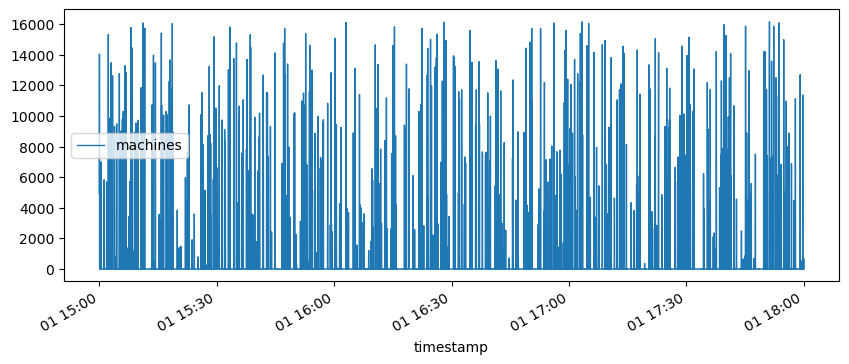

In [37]:
df.plot.line(y='machines',figsize = (10,4),lw = 1);

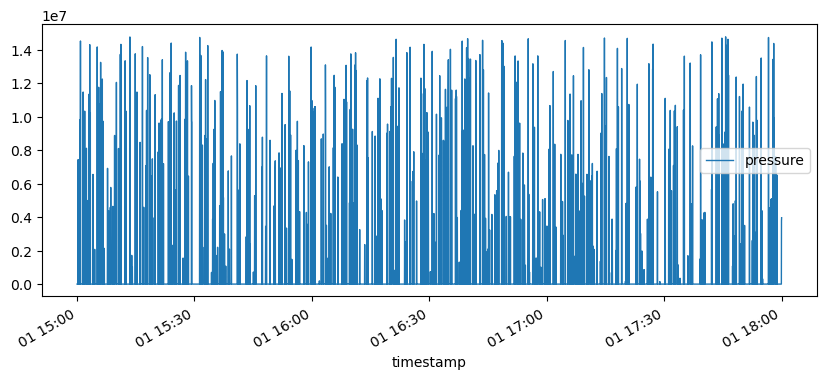

In [38]:
df.plot.line(y='pressure',figsize = (10,4),lw = 1);

[Text(0.5, 0, 'timestamp'), Text(0, 0.5, 'machines')]

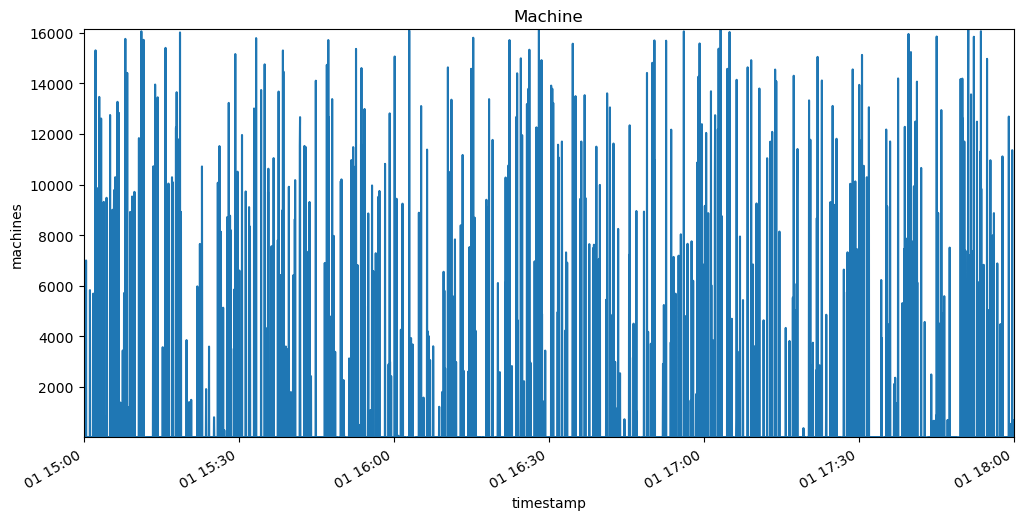

In [39]:
ax = df['machines'].plot(figsize=(12,6),title = 'Machine');
ax.autoscale(axis='both',tight=True)
ax.set(xlabel = 'timestamp', ylabel = 'machines')

[Text(0.5, 0, 'timestamp'), Text(0, 0.5, 'Pressure')]

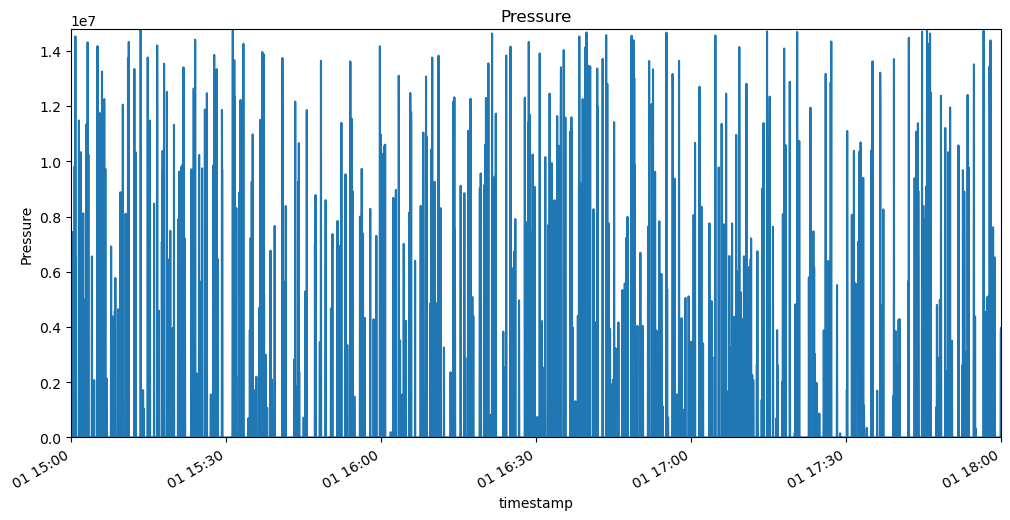

In [40]:
ax = df['pressure'].plot(figsize=(12,6),title = 'Pressure');
ax.autoscale(axis='both',tight=True)
ax.set(xlabel = 'timestamp', ylabel = 'Pressure')

<Axes: xlabel='timestamp'>

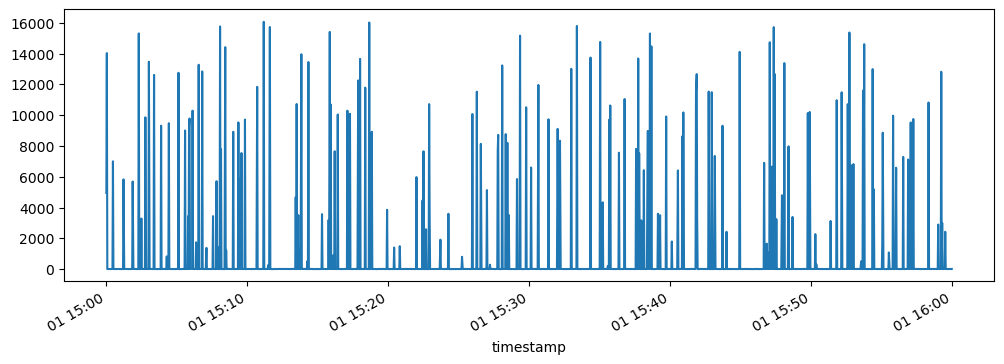

In [41]:
df['machines']['2023-06-01 15:00:00':'2023-06-01 16:00:00'].plot(figsize=(12,4)) #plot level

<Axes: xlabel='timestamp'>

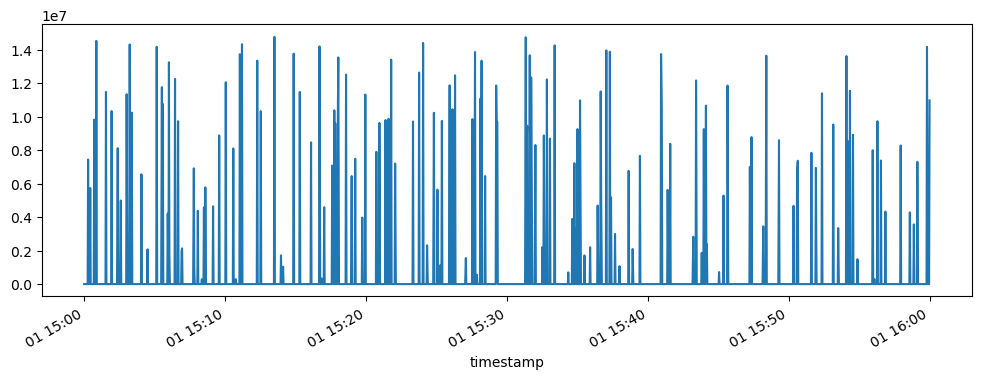

In [42]:
df['pressure']['2023-06-01 15:00:00':'2023-06-01 16:00:00'].plot(figsize=(12,4)) #plot level

<Axes: xlabel='timestamp'>

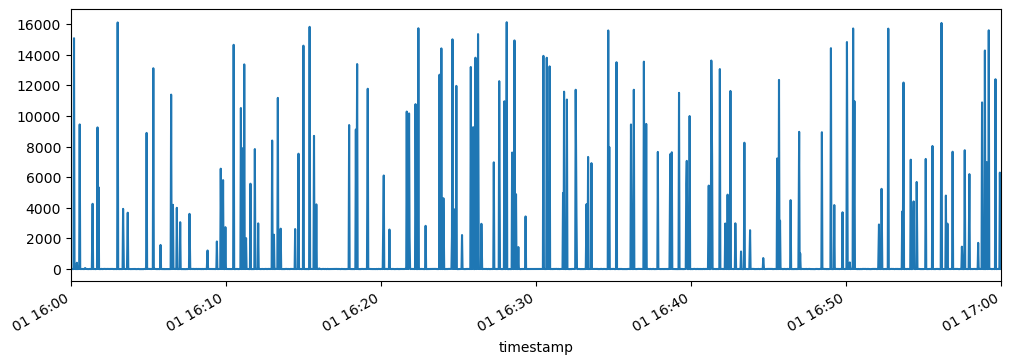

In [43]:
df['machines'].plot(figsize=(12,4),xlim = ['2023-06-01 16:00:00','2023-06-01 17:00:00']) # dataframe level

<Axes: xlabel='timestamp'>

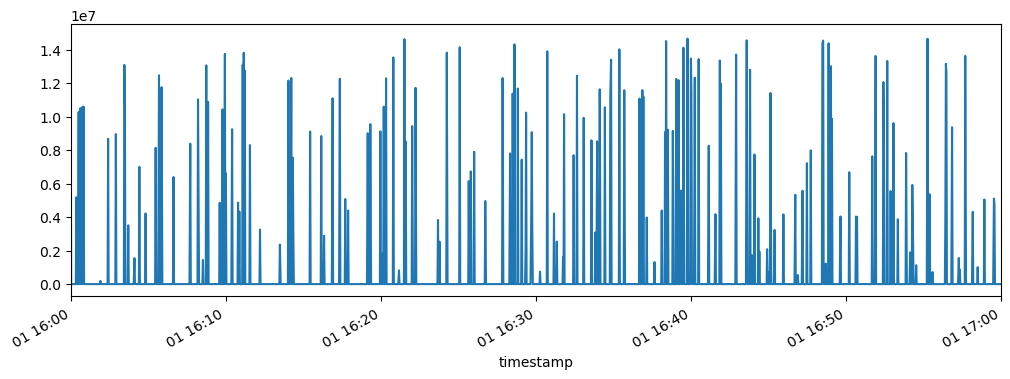

In [44]:
df['pressure'].plot(figsize=(12,4),xlim = ['2023-06-01 16:00:00','2023-06-01 17:00:00']) # dataframe level

<Axes: >

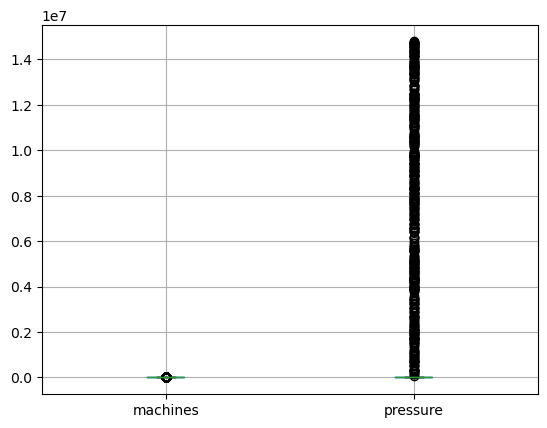

In [45]:
df.boxplot()

<Axes: >

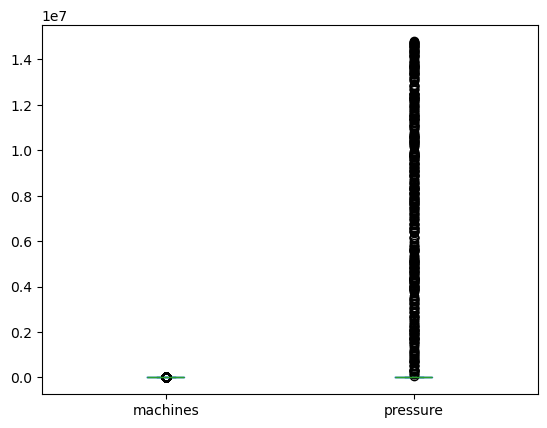

In [46]:
df.plot.box()

<Axes: ylabel='Density'>

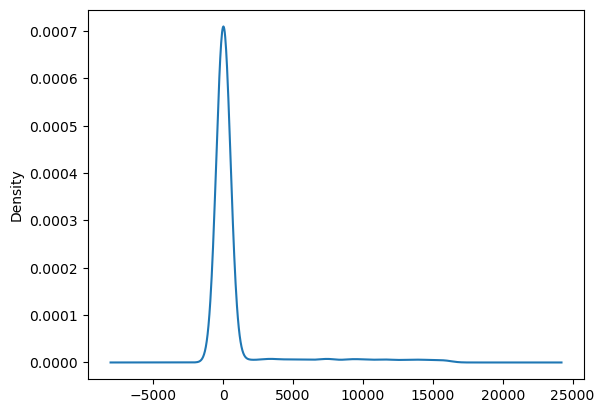

In [47]:
df['machines'].plot.kde()

<Axes: ylabel='Density'>

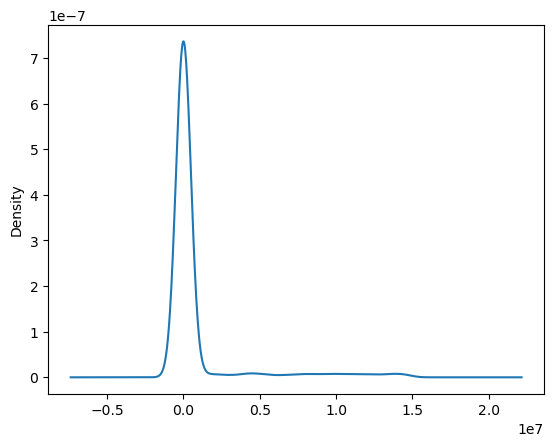

In [48]:
df['pressure'].plot.kde()

<Axes: xlabel='timestamp'>

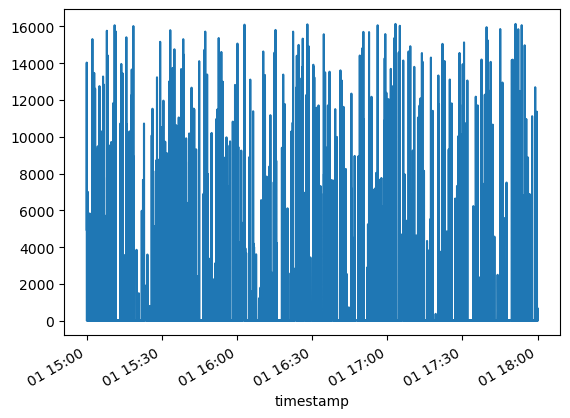

In [49]:
df['machines'].plot()

<Axes: xlabel='timestamp'>

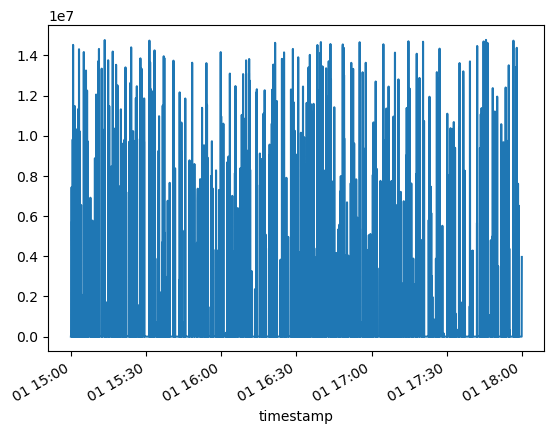

In [50]:
df['pressure'].plot()

## Time Resampling

In [51]:
df.resample(rule='T').mean()

machines      pressure
timestamp                                     
2023-06-01 15:00:00   934.785714  1.584936e+06
2023-06-01 15:01:00   418.285714  7.797136e+05
2023-06-01 15:02:00  1022.464286  4.689306e+05
2023-06-01 15:03:00  1316.814815  1.329907e+06
2023-06-01 15:04:00   374.750000  3.090074e+05
...                          ...           ...
2023-06-01 17:56:00   569.500000  6.895071e+05
2023-06-01 17:57:00   563.750000  2.124496e+06
2023-06-01 17:58:00     6.962963  5.239182e+05
2023-06-01 17:59:00   910.785714  1.356822e+05
2023-06-01 18:00:00    10.000000  3.967339e+06

[181 rows x 2 columns]

In [52]:
df.resample(rule='T').min()

machines  pressure
timestamp                              
2023-06-01 15:00:00         1         5
2023-06-01 15:01:00         1        34
2023-06-01 15:02:00         1        61
2023-06-01 15:03:00         1        29
2023-06-01 15:04:00         1        94
...                       ...       ...
2023-06-01 17:56:00         1        65
2023-06-01 17:57:00         1        58
2023-06-01 17:58:00         1         4
2023-06-01 17:59:00         2        84
2023-06-01 18:00:00        10   3967339

[181 rows x 2 columns]

In [53]:
df.resample(rule='T').max()

machines  pressure
timestamp                              
2023-06-01 15:00:00     14031  14525390
2023-06-01 15:01:00      5828  11476633
2023-06-01 15:02:00     15309   8116837
2023-06-01 15:03:00     13468  14309053
2023-06-01 15:04:00      9479   6555219
...                       ...       ...
2023-06-01 17:56:00      8872  14735150
2023-06-01 17:57:00     11116  14379324
2023-06-01 17:58:00        14   7612001
2023-06-01 17:59:00     12691   3775428
2023-06-01 18:00:00        10   3967339

[181 rows x 2 columns]

In [54]:
df.resample(rule='T').std()

machines      pressure
timestamp                                     
2023-06-01 15:00:00  3017.850797  3.692549e+06
2023-06-01 15:01:00  1508.410983  2.863988e+06
2023-06-01 15:02:00  3405.436432  1.770883e+06
2023-06-01 15:03:00  3825.437100  3.875313e+06
2023-06-01 15:04:00  1790.940651  1.285372e+06
...                          ...           ...
2023-06-01 17:56:00  2081.865590  2.883719e+06
2023-06-01 17:57:00  2234.274422  4.490136e+06
2023-06-01 17:58:00     4.493427  1.891310e+06
2023-06-01 17:59:00  3148.756173  7.133232e+05
2023-06-01 18:00:00          NaN           NaN

[181 rows x 2 columns]

In [55]:
def first_day(entry):
    if len(entry):
        return entry[0]

In [56]:
df.resample(rule='T').apply(first_day)

C:\Users\Ruman\AppData\Local\Temp\ipykernel_7328\710633468.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return entry[0]


machines  pressure
timestamp                              
2023-06-01 15:00:00      4948      1426
2023-06-01 15:01:00        11      1090
2023-06-01 15:02:00         6       244
2023-06-01 15:03:00     13468  11340972
2023-06-01 15:04:00        14      1499
...                       ...       ...
2023-06-01 17:56:00         9      1437
2023-06-01 17:57:00         6       735
2023-06-01 17:58:00        13        57
2023-06-01 17:59:00        13      1081
2023-06-01 18:00:00        10   3967339

[181 rows x 2 columns]

<Axes: xlabel='timestamp'>

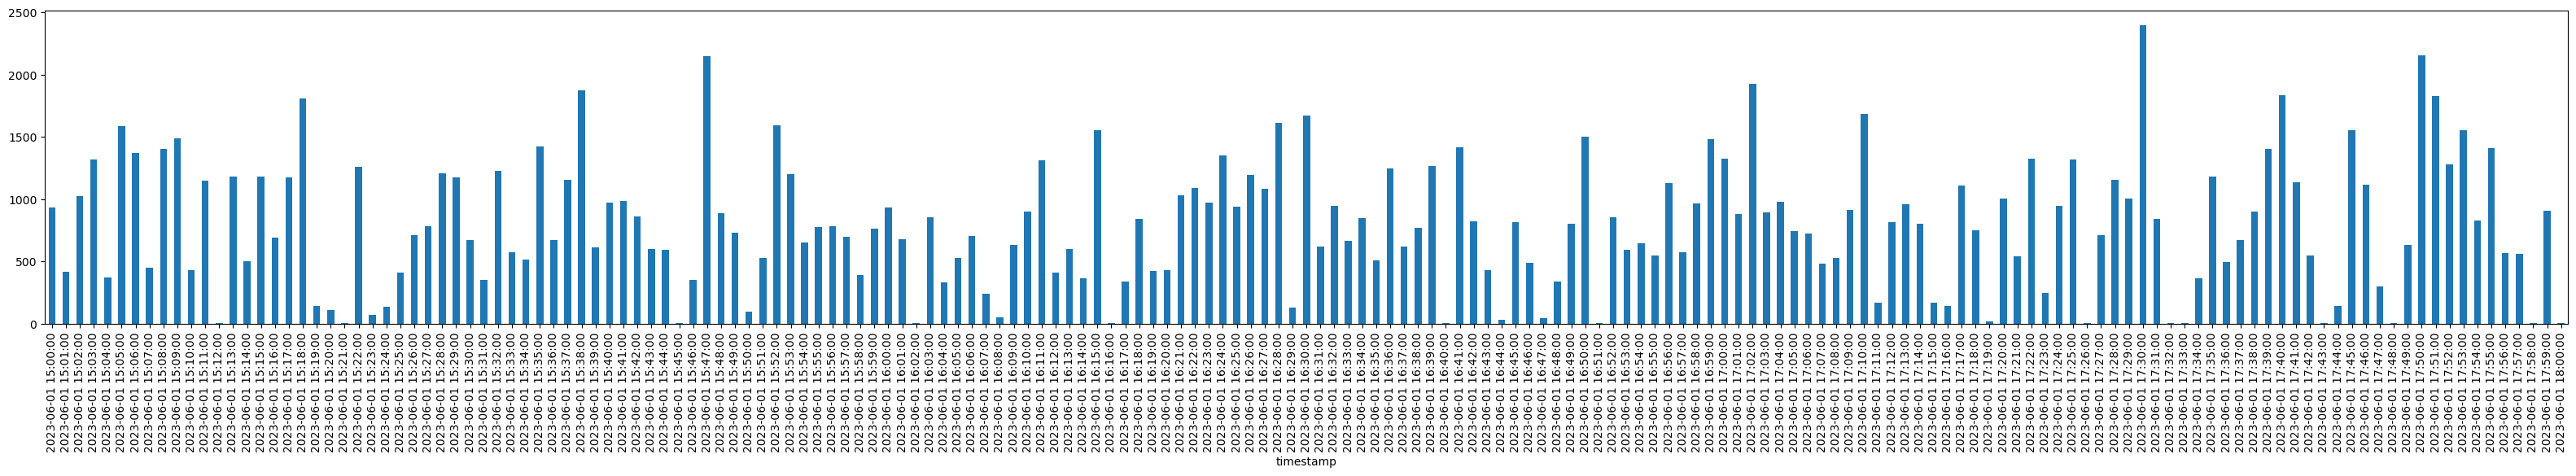

In [57]:
df['machines'].resample('T').mean().plot.bar(figsize=(40, 5))

<Axes: xlabel='timestamp'>

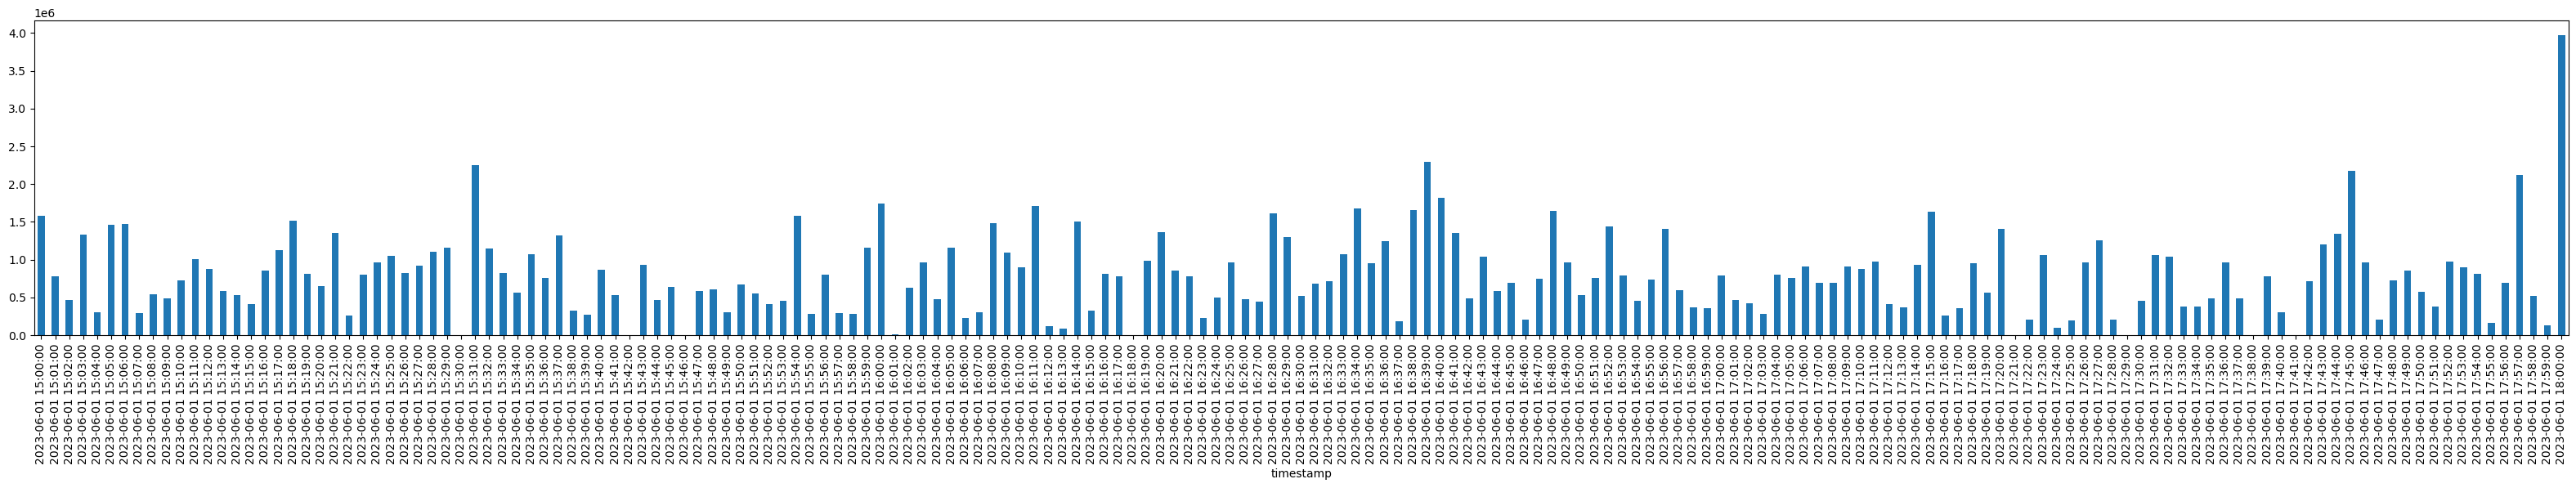

In [58]:
df['pressure'].resample('T').mean().plot.bar(figsize=(40, 5))

In [59]:
df = df.resample('T').mean()

## Rolling and Expanding

### Rolling

<Axes: xlabel='timestamp'>

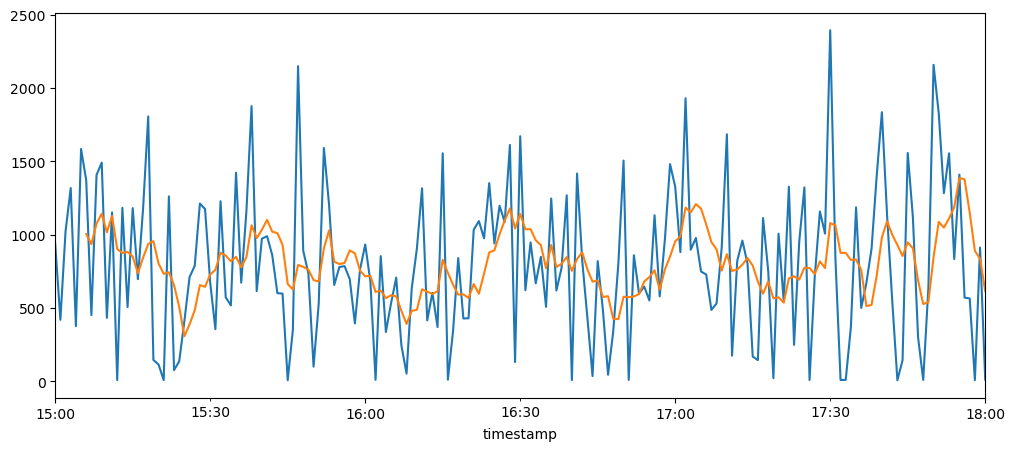

In [60]:
df['machines'].plot(figsize=(12,5))
df.rolling(window=7).mean()['machines'].plot()

<Axes: xlabel='timestamp'>

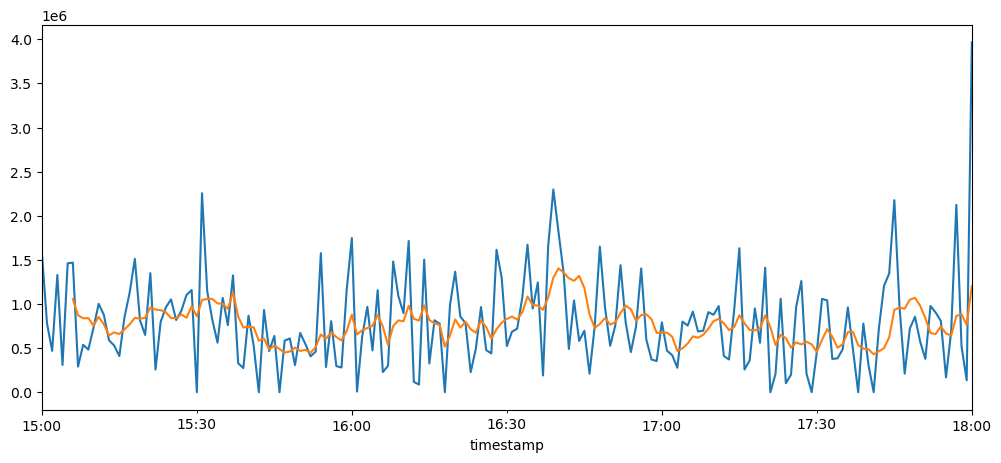

In [61]:
df['pressure'].plot(figsize=(12,5))
df.rolling(window=7).mean()['pressure'].plot()

<Axes: xlabel='timestamp'>

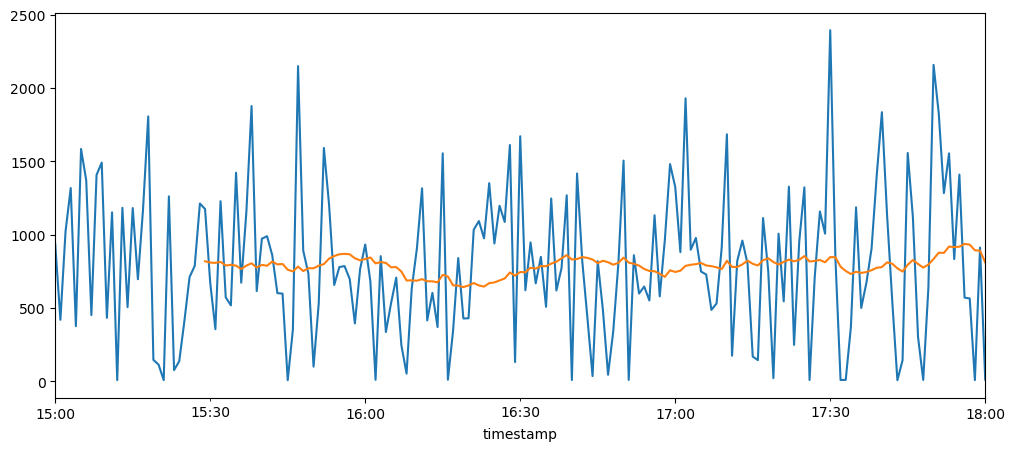

In [62]:
df['machines'].plot(figsize=(12,5))
df.rolling(window=30).mean()['machines'].plot()

<Axes: xlabel='timestamp'>

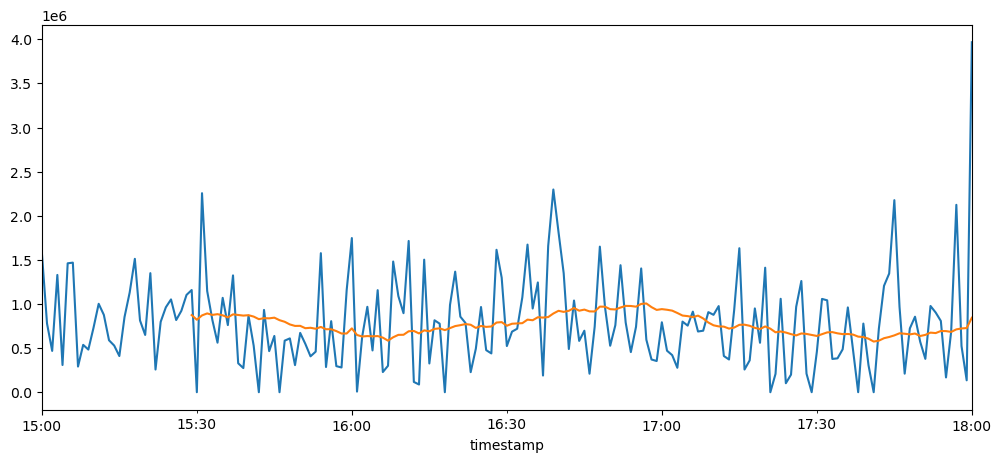

In [63]:
df['pressure'].plot(figsize=(12,5))
df.rolling(window=30).mean()['pressure'].plot()

<Axes: xlabel='timestamp'>

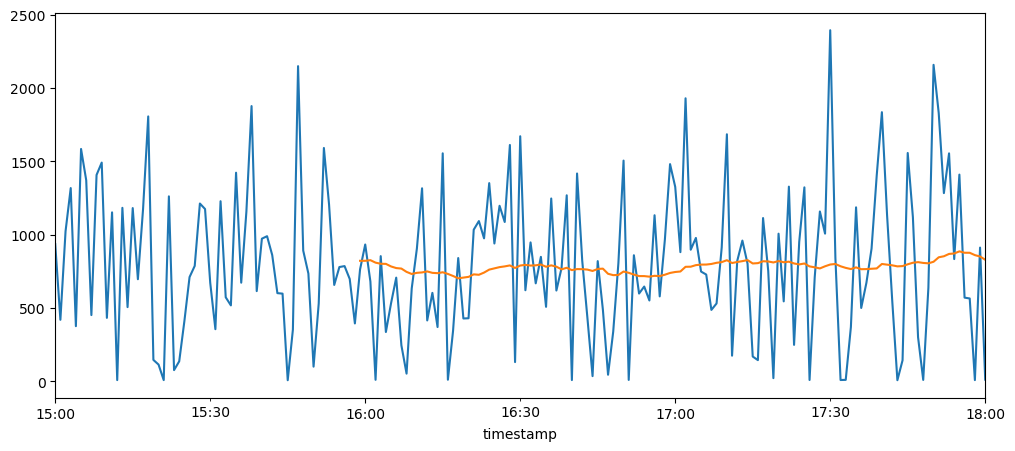

In [64]:
df['machines'].plot(figsize=(12,5))
df.rolling(window=60).mean()['machines'].plot() 

<Axes: xlabel='timestamp'>

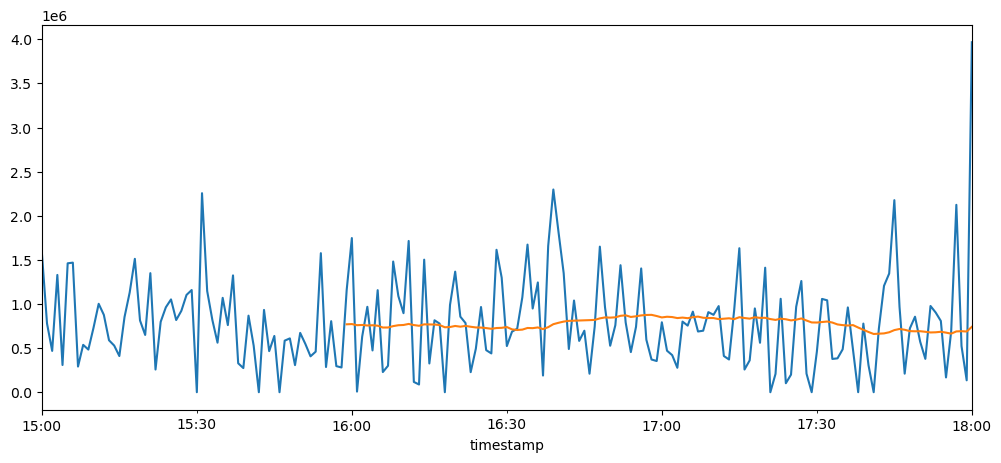

In [65]:
df['pressure'].plot(figsize=(12,5))
df.rolling(window=60).mean()['pressure'].plot() 

In [66]:
df['machines : 30 Day Mean'] = df['machines'].rolling(window=30).mean()

In [67]:
df['pressure : 30 Day Mean'] = df['pressure'].rolling(window=30).mean()

In [68]:
df.head()

machines      pressure  machines : 30 Day Mean  \
timestamp                                                                
2023-06-01 15:00:00   934.785714  1.584936e+06                     NaN   
2023-06-01 15:01:00   418.285714  7.797136e+05                     NaN   
2023-06-01 15:02:00  1022.464286  4.689306e+05                     NaN   
2023-06-01 15:03:00  1316.814815  1.329907e+06                     NaN   
2023-06-01 15:04:00   374.750000  3.090074e+05                     NaN   

                     pressure : 30 Day Mean  
timestamp                                    
2023-06-01 15:00:00                     NaN  
2023-06-01 15:01:00                     NaN  
2023-06-01 15:02:00                     NaN  
2023-06-01 15:03:00                     NaN  
2023-06-01 15:04:00                     NaN

<Axes: xlabel='timestamp'>

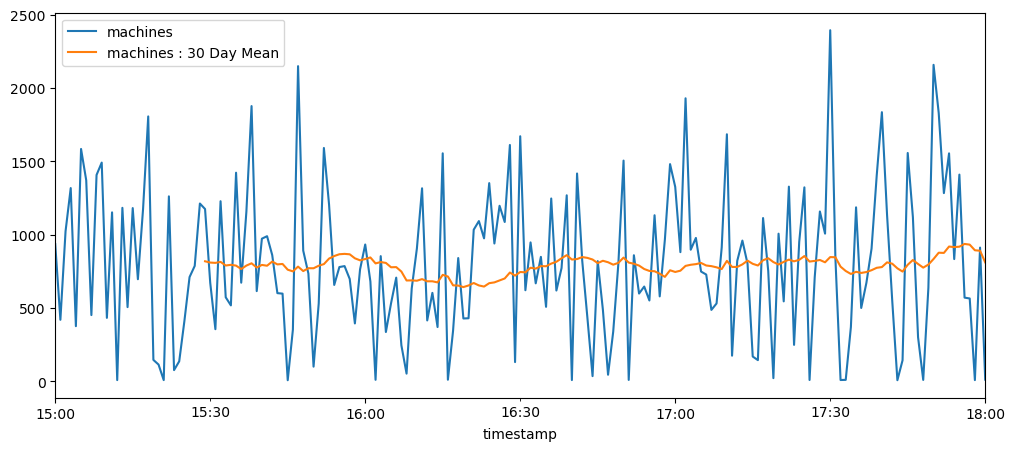

In [69]:
df[['machines','machines : 30 Day Mean']].plot(figsize=(12,5))

<Axes: xlabel='timestamp'>

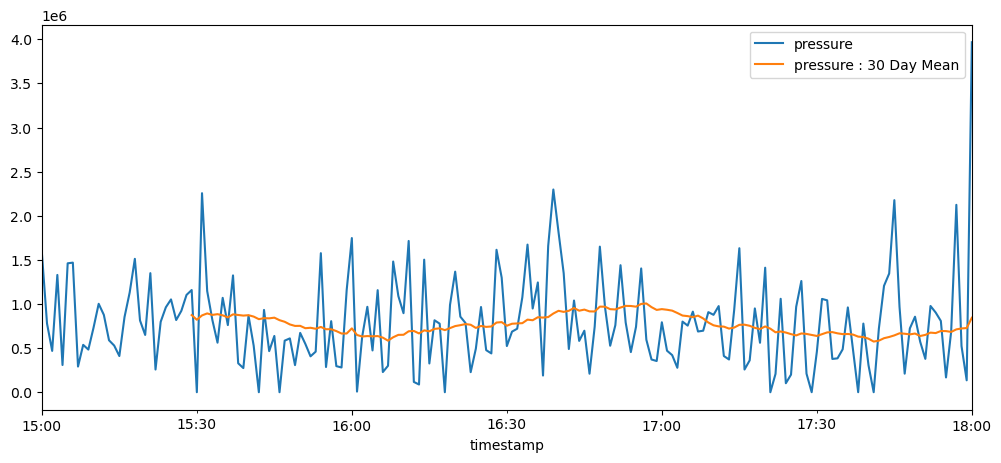

In [70]:
df[['pressure','pressure : 30 Day Mean']].plot(figsize=(12,5))

In [71]:
df.tail()

machines      pressure  machines : 30 Day Mean  \
timestamp                                                               
2023-06-01 17:56:00  569.500000  6.895071e+05              935.747222   
2023-06-01 17:57:00  563.750000  2.124496e+06              930.893651   
2023-06-01 17:58:00    6.962963  5.239182e+05              892.560317   
2023-06-01 17:59:00  910.785714  1.356822e+05              889.381746   
2023-06-01 18:00:00   10.000000  3.967339e+06              809.932937   

                     pressure : 30 Day Mean  
timestamp                                    
2023-06-01 17:56:00           684075.364374  
2023-06-01 17:57:00           712860.959612  
2023-06-01 17:58:00           723299.046032  
2023-06-01 17:59:00           727798.661508  
2023-06-01 18:00:00           844741.205556

### Expanding

<Axes: xlabel='timestamp'>

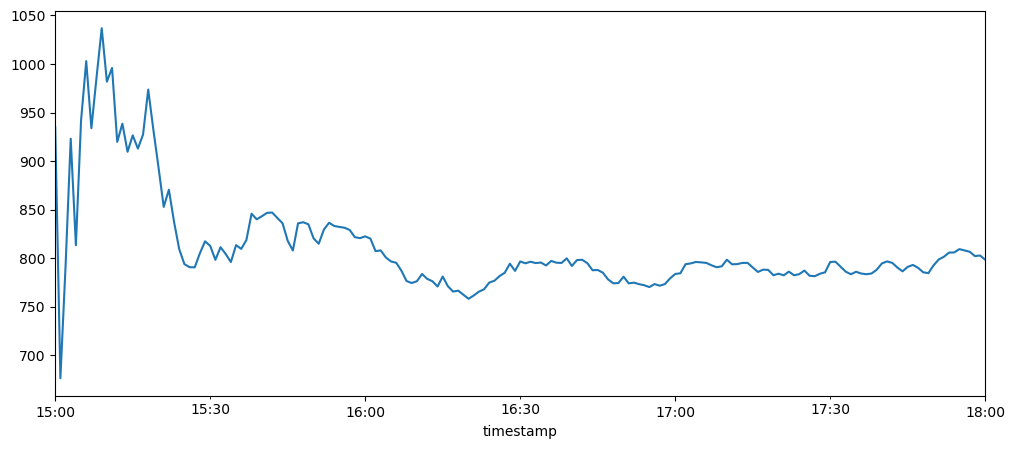

In [72]:
df['machines'].expanding().mean().plot(figsize=(12,5))

<Axes: xlabel='timestamp'>

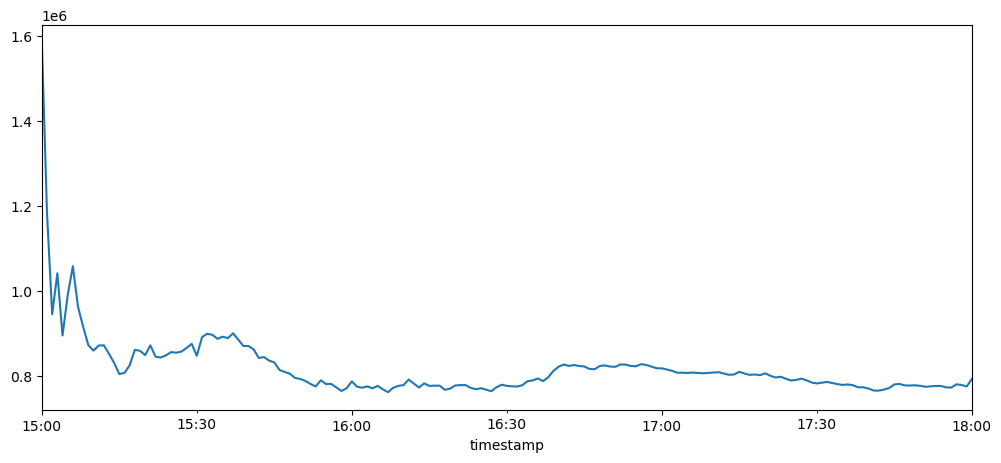

In [73]:
df['pressure'].expanding().mean().plot(figsize=(12,5))

## HP Filter

In [74]:
machines_trend,machines_cycle = hpfilter(df['machines'],lamb=1600)

In [75]:
pressure_trend,pressure_cycle = hpfilter(df['pressure'],lamb=1600)

In [76]:
type(machines_trend)

pandas.core.series.Series

In [77]:
type(pressure_trend)

pandas.core.series.Series

<Axes: xlabel='timestamp'>

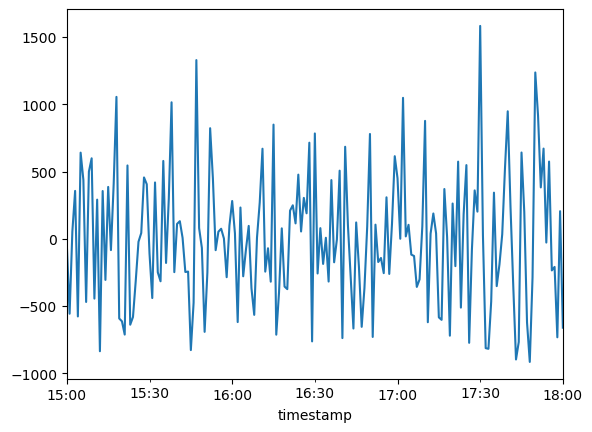

In [78]:
machines_trend.plot()

<Axes: xlabel='timestamp'>

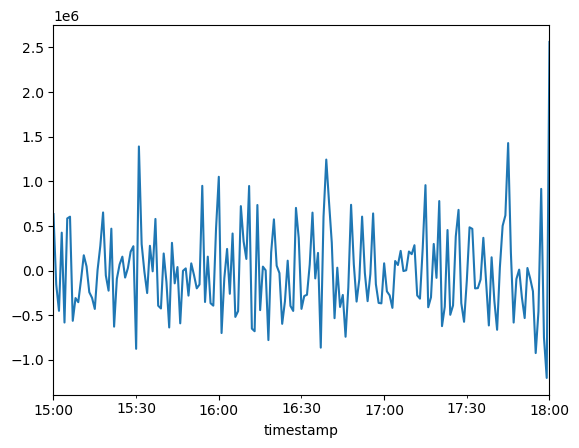

In [79]:
pressure_trend.plot()

In [80]:
df['machines trend'] = machines_trend

In [81]:
df['pressure trend'] = pressure_trend

In [82]:
df.head()

machines      pressure  machines : 30 Day Mean  \
timestamp                                                                
2023-06-01 15:00:00   934.785714  1.584936e+06                     NaN   
2023-06-01 15:01:00   418.285714  7.797136e+05                     NaN   
2023-06-01 15:02:00  1022.464286  4.689306e+05                     NaN   
2023-06-01 15:03:00  1316.814815  1.329907e+06                     NaN   
2023-06-01 15:04:00   374.750000  3.090074e+05                     NaN   

                     pressure : 30 Day Mean  machines trend  pressure trend  
timestamp                                                                    
2023-06-01 15:00:00                     NaN      -48.198437   633652.338442  
2023-06-01 15:01:00                     NaN     -557.479150  -155578.231967  
2023-06-01 15:02:00                     NaN       53.948833  -450765.120802  
2023-06-01 15:03:00                     NaN      355.957447   425112.704986  
2023-06-01 15:04:00                     NaN     -577.695781  -581597.739386

<Axes: xlabel='timestamp'>

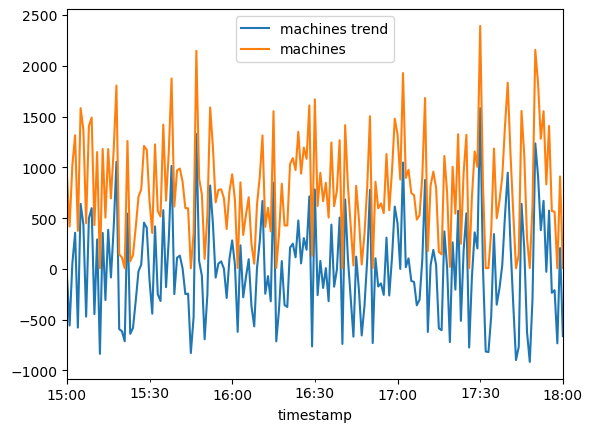

In [83]:
df[['machines trend','machines']].plot()

<Axes: xlabel='timestamp'>

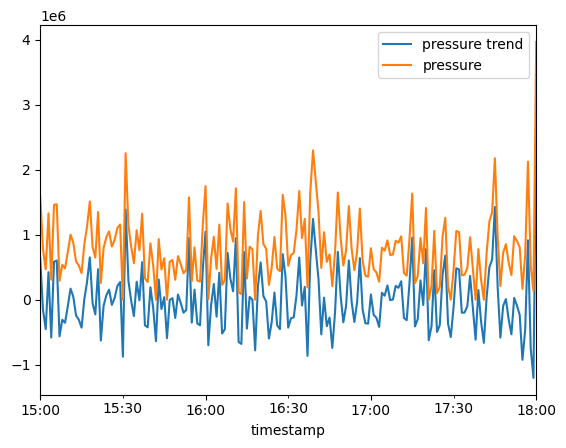

In [84]:
df[['pressure trend','pressure']].plot()

<Axes: xlabel='timestamp'>

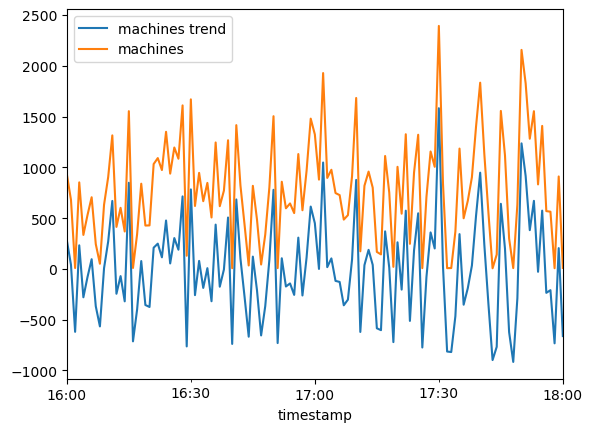

In [85]:
df[['machines trend','machines']]['2023-06-01 16:00:00':].plot()

<Axes: xlabel='timestamp'>

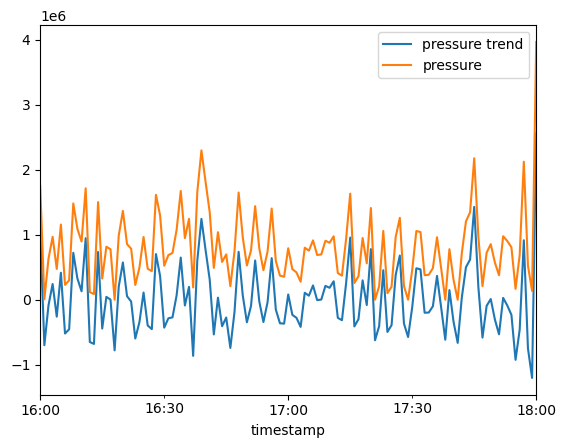

In [86]:
df[['pressure trend','pressure']]['2023-06-01 16:00:00':].plot()

## ETS Decomposition

In [87]:
machines_result = seasonal_decompose(df['machines'], model='multiplicative', period=60)

In [88]:
pressure_result = seasonal_decompose(df['pressure'], model='multiplicative', period=60)

In [89]:
machines_result

In [90]:
pressure_result

In [91]:
machines_result.seasonal

timestamp
2023-06-01 15:00:00    1.420977
2023-06-01 15:01:00    0.970828
2023-06-01 15:02:00    1.211316
2023-06-01 15:03:00    1.104100
2023-06-01 15:04:00    0.837624
                         ...   
2023-06-01 17:56:00    1.207697
2023-06-01 17:57:00    0.808496
2023-06-01 17:58:00    0.866228
2023-06-01 17:59:00    1.426018
2023-06-01 18:00:00    1.420977
Freq: T, Name: seasonal, Length: 181, dtype: float64

In [92]:
pressure_result.seasonal

timestamp
2023-06-01 15:00:00    1.725025
2023-06-01 15:01:00    0.308293
2023-06-01 15:02:00    0.722397
2023-06-01 15:03:00    0.875792
2023-06-01 15:04:00    0.860447
                         ...   
2023-06-01 17:56:00    1.437275
2023-06-01 17:57:00    0.575294
2023-06-01 17:58:00    0.427728
2023-06-01 17:59:00    1.036057
2023-06-01 18:00:00    1.725025
Freq: T, Name: seasonal, Length: 181, dtype: float64

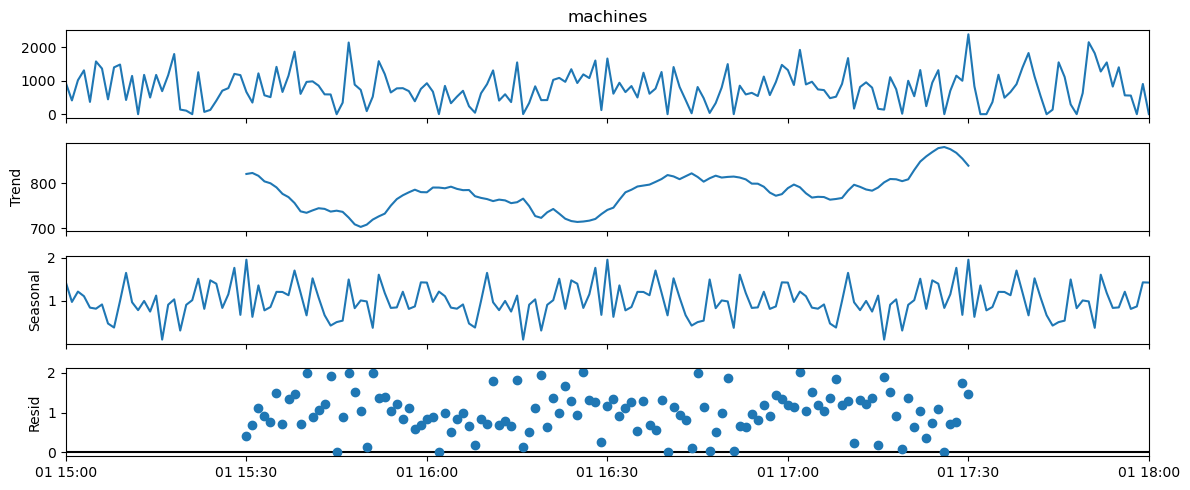

In [93]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,5

machines_result.plot();

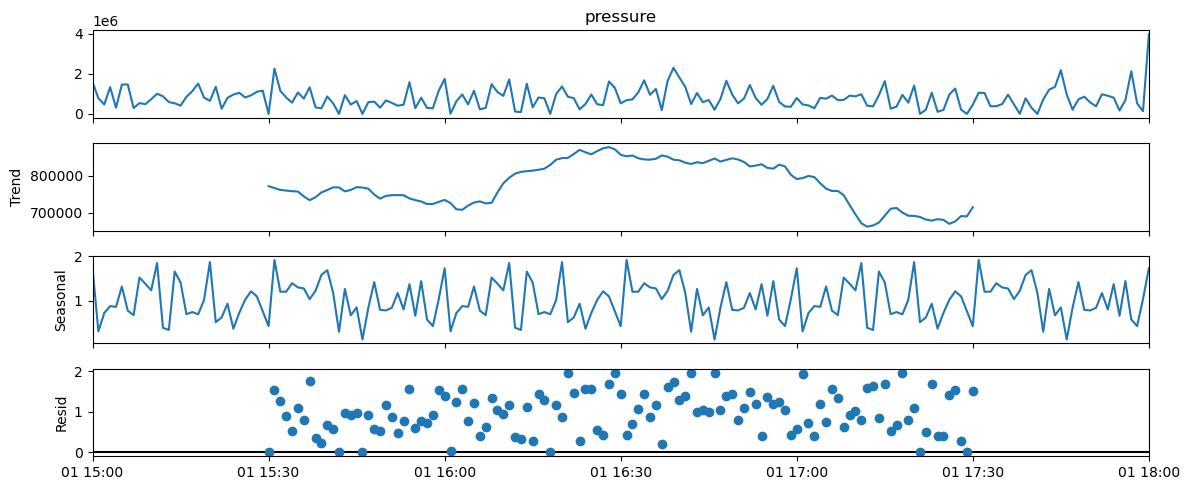

In [94]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,5

pressure_result.plot();

### EWMA

In [95]:
df['machines_6-minute-SMA'] = df['machines'].rolling(window=6).mean()

In [96]:
df['pressure_6-minute-SMA'] = df['machines'].rolling(window=6).mean()

In [97]:
df.tail()

machines      pressure  machines : 30 Day Mean  \
timestamp                                                               
2023-06-01 17:56:00  569.500000  6.895071e+05              935.747222   
2023-06-01 17:57:00  563.750000  2.124496e+06              930.893651   
2023-06-01 17:58:00    6.962963  5.239182e+05              892.560317   
2023-06-01 17:59:00  910.785714  1.356822e+05              889.381746   
2023-06-01 18:00:00   10.000000  3.967339e+06              809.932937   

                     pressure : 30 Day Mean  machines trend  pressure trend  \
timestamp                                                                     
2023-06-01 17:56:00           684075.364374     -235.441103   -4.589846e+05   
2023-06-01 17:57:00           712860.959612     -209.318719    9.155743e+05   
2023-06-01 17:58:00           723299.046032     -732.791714   -7.482664e+05   
2023-06-01 17:59:00           727798.661508      205.043573   -1.202217e+06   
2023-06-01 18:00:00           844741.205556     -661.316283    2.562124e+06   

                     machines_6-minute-SMA  pressure_6-minute-SMA  
timestamp                                                          
2023-06-01 17:56:00            1245.806658            1245.806658  
2023-06-01 17:57:00            1035.062610            1035.062610  
2023-06-01 17:58:00             822.490961             822.490961  
2023-06-01 17:59:00             715.360009             715.360009  
2023-06-01 18:00:00             578.273589             578.273589

<Axes: xlabel='timestamp'>

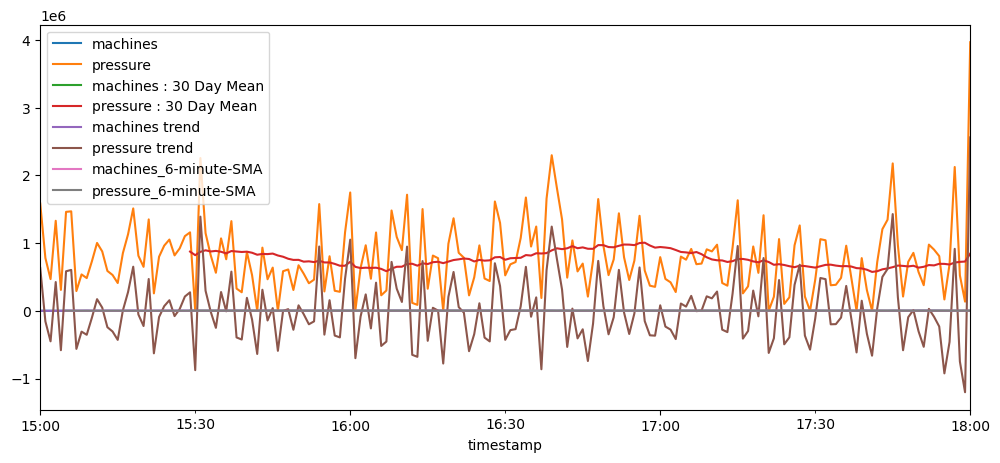

In [98]:
df.plot()

In [99]:
 df['machines_EWMA-12'] = df['machines'].ewm(span=12).mean()

In [100]:
 df['pressure_EWMA-12'] = df['pressure'].ewm(span=12).mean()

<Axes: xlabel='timestamp'>

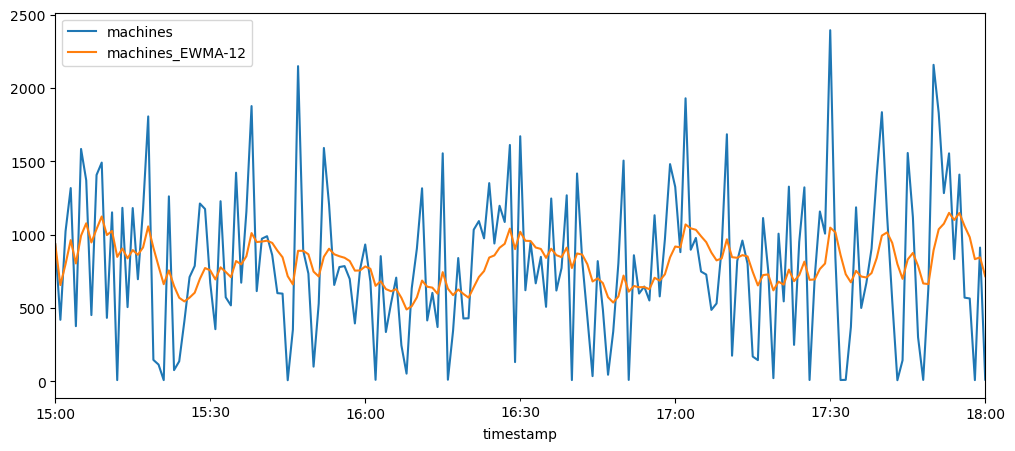

In [101]:
 df[['machines','machines_EWMA-12']].plot()

<Axes: xlabel='timestamp'>

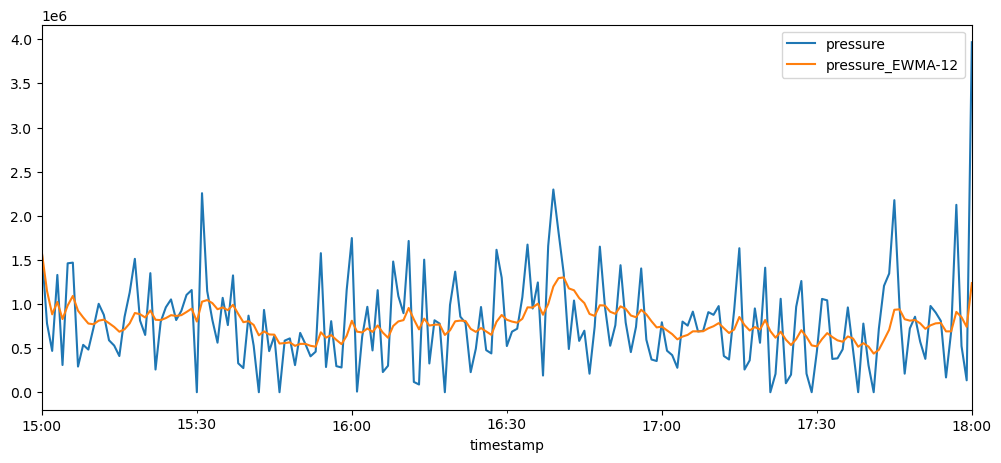

In [102]:
 df[['pressure','pressure_EWMA-12']].plot()

### Holt Winters Method

In [103]:
df.index

DatetimeIndex(['2023-06-01 15:00:00', '2023-06-01 15:01:00',
               '2023-06-01 15:02:00', '2023-06-01 15:03:00',
               '2023-06-01 15:04:00', '2023-06-01 15:05:00',
               '2023-06-01 15:06:00', '2023-06-01 15:07:00',
               '2023-06-01 15:08:00', '2023-06-01 15:09:00',
               ...
               '2023-06-01 17:51:00', '2023-06-01 17:52:00',
               '2023-06-01 17:53:00', '2023-06-01 17:54:00',
               '2023-06-01 17:55:00', '2023-06-01 17:56:00',
               '2023-06-01 17:57:00', '2023-06-01 17:58:00',
               '2023-06-01 17:59:00', '2023-06-01 18:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=181, freq='T')

In [104]:
inferred_freq = pd.infer_freq(df.index)
print(f"Inferred Frequency: {inferred_freq}")

Inferred Frequency: T


In [105]:
span = 12
alpha = 2/(span + 1)

In [106]:
df['machines_EWMA12'] = df['machines'].ewm(alpha=alpha,adjust=False).mean()

In [107]:
df['pressure_EWMA12'] = df['pressure'].ewm(alpha=alpha,adjust=False).mean()

In [108]:
df.head()

machines      pressure  machines : 30 Day Mean  \
timestamp                                                                
2023-06-01 15:00:00   934.785714  1.584936e+06                     NaN   
2023-06-01 15:01:00   418.285714  7.797136e+05                     NaN   
2023-06-01 15:02:00  1022.464286  4.689306e+05                     NaN   
2023-06-01 15:03:00  1316.814815  1.329907e+06                     NaN   
2023-06-01 15:04:00   374.750000  3.090074e+05                     NaN   

                     pressure : 30 Day Mean  machines trend  pressure trend  \
timestamp                                                                     
2023-06-01 15:00:00                     NaN      -48.198437   633652.338442   
2023-06-01 15:01:00                     NaN     -557.479150  -155578.231967   
2023-06-01 15:02:00                     NaN       53.948833  -450765.120802   
2023-06-01 15:03:00                     NaN      355.957447   425112.704986   
2023-06-01 15:04:00                     NaN     -577.695781  -581597.739386   

                     machines_6-minute-SMA  pressure_6-minute-SMA  \
timestamp                                                           
2023-06-01 15:00:00                    NaN                    NaN   
2023-06-01 15:01:00                    NaN                    NaN   
2023-06-01 15:02:00                    NaN                    NaN   
2023-06-01 15:03:00                    NaN                    NaN   
2023-06-01 15:04:00                    NaN                    NaN   

                     machines_EWMA-12  pressure_EWMA-12  machines_EWMA12  \
timestamp                                                                  
2023-06-01 15:00:00        934.785714      1.584936e+06       934.785714   
2023-06-01 15:01:00        655.014881      1.148774e+06       855.324176   
2023-06-01 15:02:00        798.430468      8.834310e+05       881.038039   
2023-06-01 15:03:00        962.064148      1.024366e+06       948.080620   
2023-06-01 15:04:00        802.492993      8.300057e+05       859.875909   

                     pressure_EWMA12  
timestamp                             
2023-06-01 15:00:00     1.584936e+06  
2023-06-01 15:01:00     1.461056e+06  
2023-06-01 15:02:00     1.308421e+06  
2023-06-01 15:03:00     1.311727e+06  
2023-06-01 15:04:00     1.157462e+06

In [109]:
machines_model = SimpleExpSmoothing(df['machines'])

In [110]:
machines_fitted_model = machines_model.fit(smoothing_level = alpha,optimized = False)

In [111]:
df['machines_SES12'] = machines_fitted_model.fittedvalues.shift(-1)

In [112]:
df['pressure_SES12'] = machines_fitted_model.fittedvalues.shift(-1)

In [113]:
df.head()

machines      pressure  machines : 30 Day Mean  \
timestamp                                                                
2023-06-01 15:00:00   934.785714  1.584936e+06                     NaN   
2023-06-01 15:01:00   418.285714  7.797136e+05                     NaN   
2023-06-01 15:02:00  1022.464286  4.689306e+05                     NaN   
2023-06-01 15:03:00  1316.814815  1.329907e+06                     NaN   
2023-06-01 15:04:00   374.750000  3.090074e+05                     NaN   

                     pressure : 30 Day Mean  machines trend  pressure trend  \
timestamp                                                                     
2023-06-01 15:00:00                     NaN      -48.198437   633652.338442   
2023-06-01 15:01:00                     NaN     -557.479150  -155578.231967   
2023-06-01 15:02:00                     NaN       53.948833  -450765.120802   
2023-06-01 15:03:00                     NaN      355.957447   425112.704986   
2023-06-01 15:04:00                     NaN     -577.695781  -581597.739386   

                     machines_6-minute-SMA  pressure_6-minute-SMA  \
timestamp                                                           
2023-06-01 15:00:00                    NaN                    NaN   
2023-06-01 15:01:00                    NaN                    NaN   
2023-06-01 15:02:00                    NaN                    NaN   
2023-06-01 15:03:00                    NaN                    NaN   
2023-06-01 15:04:00                    NaN                    NaN   

                     machines_EWMA-12  pressure_EWMA-12  machines_EWMA12  \
timestamp                                                                  
2023-06-01 15:00:00        934.785714      1.584936e+06       934.785714   
2023-06-01 15:01:00        655.014881      1.148774e+06       855.324176   
2023-06-01 15:02:00        798.430468      8.834310e+05       881.038039   
2023-06-01 15:03:00        962.064148      1.024366e+06       948.080620   
2023-06-01 15:04:00        802.492993      8.300057e+05       859.875909   

                     pressure_EWMA12  machines_SES12  pressure_SES12  
timestamp                                                             
2023-06-01 15:00:00     1.584936e+06      934.785714      934.785714  
2023-06-01 15:01:00     1.461056e+06      855.324176      855.324176  
2023-06-01 15:02:00     1.308421e+06      881.038039      881.038039  
2023-06-01 15:03:00     1.311727e+06      948.080620      948.080620  
2023-06-01 15:04:00     1.157462e+06      859.875909      859.875909

In [114]:
df.tail()

machines      pressure  machines : 30 Day Mean  \
timestamp                                                               
2023-06-01 17:56:00  569.500000  6.895071e+05              935.747222   
2023-06-01 17:57:00  563.750000  2.124496e+06              930.893651   
2023-06-01 17:58:00    6.962963  5.239182e+05              892.560317   
2023-06-01 17:59:00  910.785714  1.356822e+05              889.381746   
2023-06-01 18:00:00   10.000000  3.967339e+06              809.932937   

                     pressure : 30 Day Mean  machines trend  pressure trend  \
timestamp                                                                     
2023-06-01 17:56:00           684075.364374     -235.441103   -4.589846e+05   
2023-06-01 17:57:00           712860.959612     -209.318719    9.155743e+05   
2023-06-01 17:58:00           723299.046032     -732.791714   -7.482664e+05   
2023-06-01 17:59:00           727798.661508      205.043573   -1.202217e+06   
2023-06-01 18:00:00           844741.205556     -661.316283    2.562124e+06   

                     machines_6-minute-SMA  pressure_6-minute-SMA  \
timestamp                                                           
2023-06-01 17:56:00            1245.806658            1245.806658   
2023-06-01 17:57:00            1035.062610            1035.062610   
2023-06-01 17:58:00             822.490961             822.490961   
2023-06-01 17:59:00             715.360009             715.360009   
2023-06-01 18:00:00             578.273589             578.273589   

                     machines_EWMA-12  pressure_EWMA-12  machines_EWMA12  \
timestamp                                                                  
2023-06-01 17:56:00       1057.951655      6.902478e+05      1057.951655   
2023-06-01 17:57:00        981.920631      9.109013e+05       981.920631   
2023-06-01 17:58:00        831.927144      8.513654e+05       831.927144   
2023-06-01 17:59:00        844.059232      7.412603e+05       844.059232   
2023-06-01 18:00:00        715.742427      1.237580e+06       715.742427   

                     pressure_EWMA12  machines_SES12  pressure_SES12  
timestamp                                                             
2023-06-01 17:56:00     6.902478e+05     1057.951655     1057.951655  
2023-06-01 17:57:00     9.109013e+05      981.920631      981.920631  
2023-06-01 17:58:00     8.513654e+05      831.927144      831.927144  
2023-06-01 17:59:00     7.412603e+05      844.059232      844.059232  
2023-06-01 18:00:00     1.237580e+06             NaN             NaN

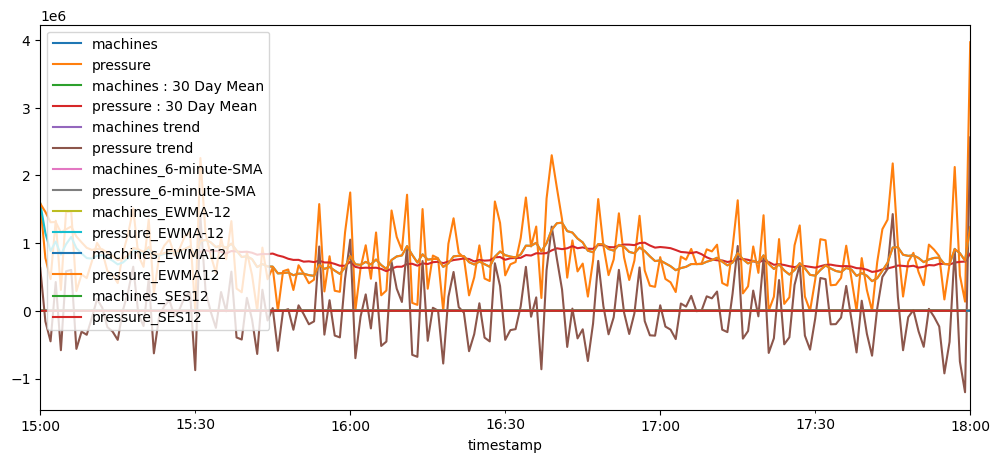

In [115]:
df.plot();

In [116]:
df['machines_DES_add_12'] = ExponentialSmoothing(df['machines'],trend ='add' ).fit().fittedvalues.shift(-1)

In [117]:
df['pressure_DES_add_12'] = ExponentialSmoothing(df['pressure'],trend ='add' ).fit().fittedvalues.shift(-1)

C:\Users\Ruman\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [118]:
df.columns

Index(['machines', 'pressure', 'machines : 30 Day Mean',
       'pressure : 30 Day Mean', 'machines trend', 'pressure trend',
       'machines_6-minute-SMA', 'pressure_6-minute-SMA', 'machines_EWMA-12',
       'pressure_EWMA-12', 'machines_EWMA12', 'pressure_EWMA12',
       'machines_SES12', 'pressure_SES12', 'machines_DES_add_12',
       'pressure_DES_add_12'],
      dtype='object')

<Axes: xlabel='timestamp'>

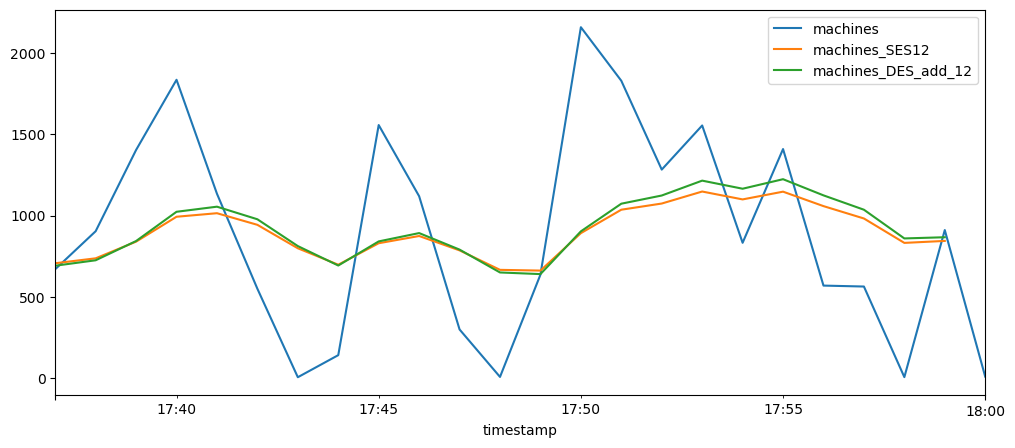

In [119]:
df[['machines','machines_SES12','machines_DES_add_12']].iloc[-24:].plot(figsize = (12,5))

<Axes: xlabel='timestamp'>

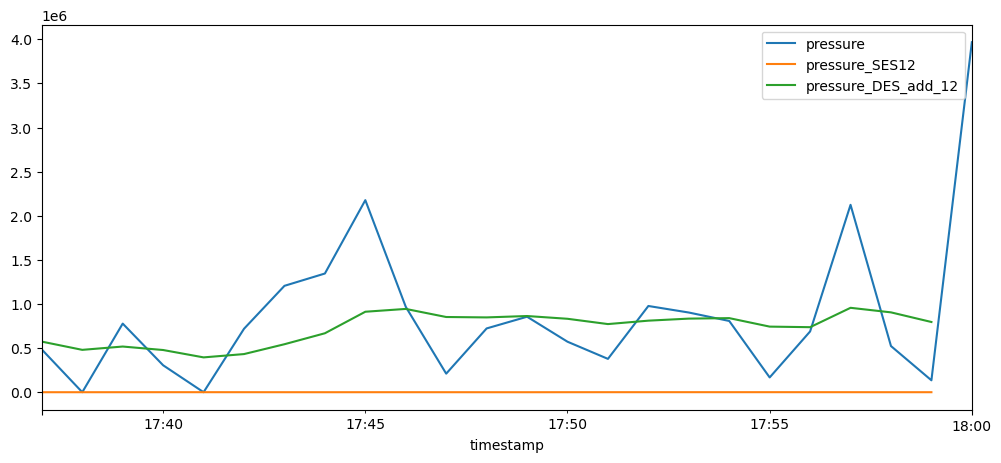

In [120]:
df[['pressure','pressure_SES12','pressure_DES_add_12']].iloc[-24:].plot(figsize = (12,5))

In [121]:
df['machines_DES_mul_12'] = ExponentialSmoothing(df['machines'],trend ='mul').fit().fittedvalues.shift(-1)

C:\Users\Ruman\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [122]:
df['pressure_DES_mul_12'] = ExponentialSmoothing(df['pressure'],trend ='mul').fit().fittedvalues.shift(-1)

C:\Users\Ruman\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='timestamp'>

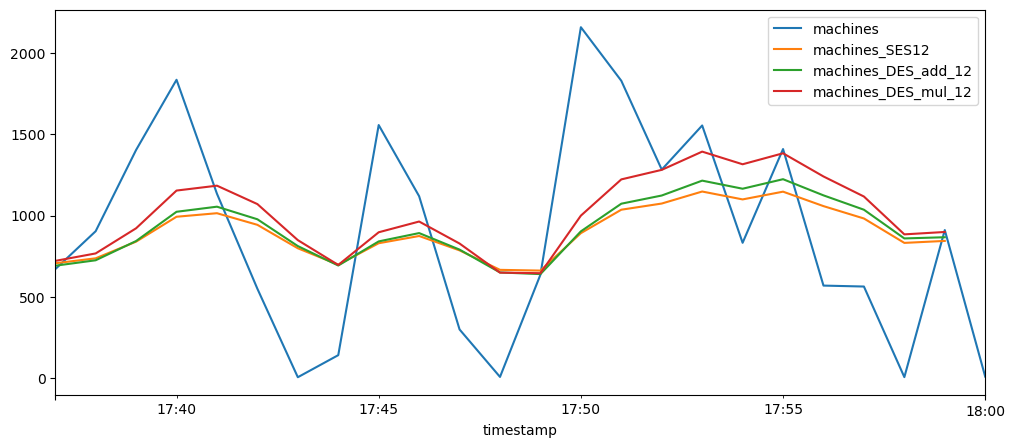

In [123]:
df[['machines','machines_SES12','machines_DES_add_12','machines_DES_mul_12']].iloc[-24:].plot(figsize = (12,5))

<Axes: xlabel='timestamp'>

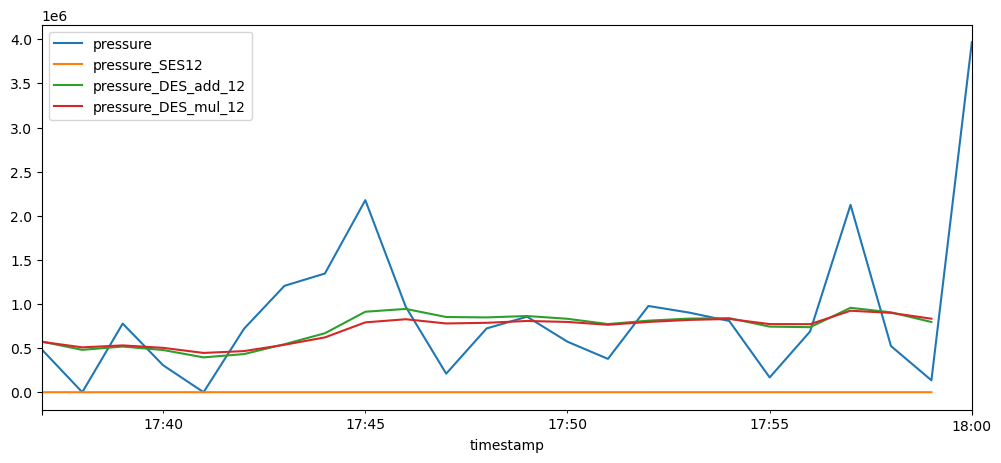

In [124]:
df[['pressure','pressure_SES12','pressure_DES_add_12','pressure_DES_mul_12']].iloc[-24:].plot(figsize = (12,5))

In [125]:
df['machines_TES_mul_12'] = ExponentialSmoothing(df['machines'],trend = 'mul',seasonal='mul',seasonal_periods = 12).fit().fittedvalues

C:\Users\Ruman\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [126]:
df['pressure_TES_mul_12'] = ExponentialSmoothing(df['machines'],trend = 'mul',seasonal='mul',seasonal_periods = 12).fit().fittedvalues

C:\Users\Ruman\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='timestamp'>

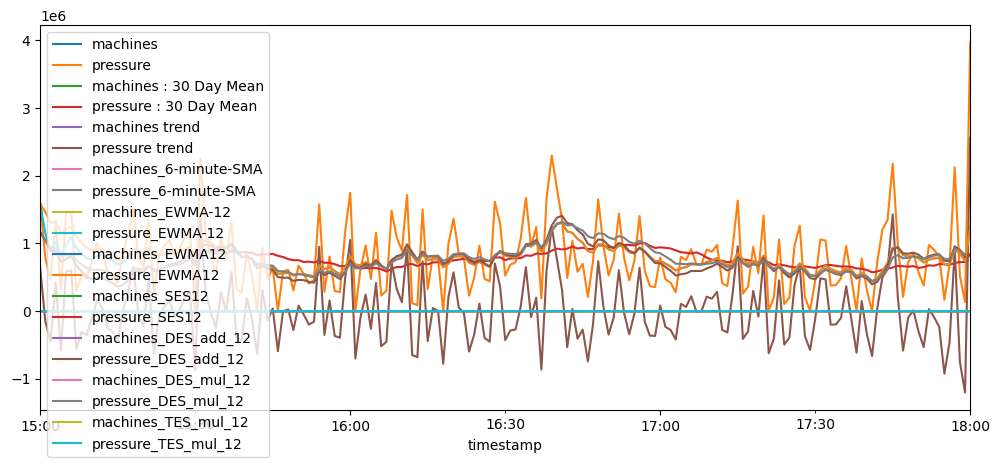

In [127]:
df.plot()

In [128]:
df.columns

Index(['machines', 'pressure', 'machines : 30 Day Mean',
       'pressure : 30 Day Mean', 'machines trend', 'pressure trend',
       'machines_6-minute-SMA', 'pressure_6-minute-SMA', 'machines_EWMA-12',
       'pressure_EWMA-12', 'machines_EWMA12', 'pressure_EWMA12',
       'machines_SES12', 'pressure_SES12', 'machines_DES_add_12',
       'pressure_DES_add_12', 'machines_DES_mul_12', 'pressure_DES_mul_12',
       'machines_TES_mul_12', 'pressure_TES_mul_12'],
      dtype='object')

<Axes: xlabel='timestamp'>

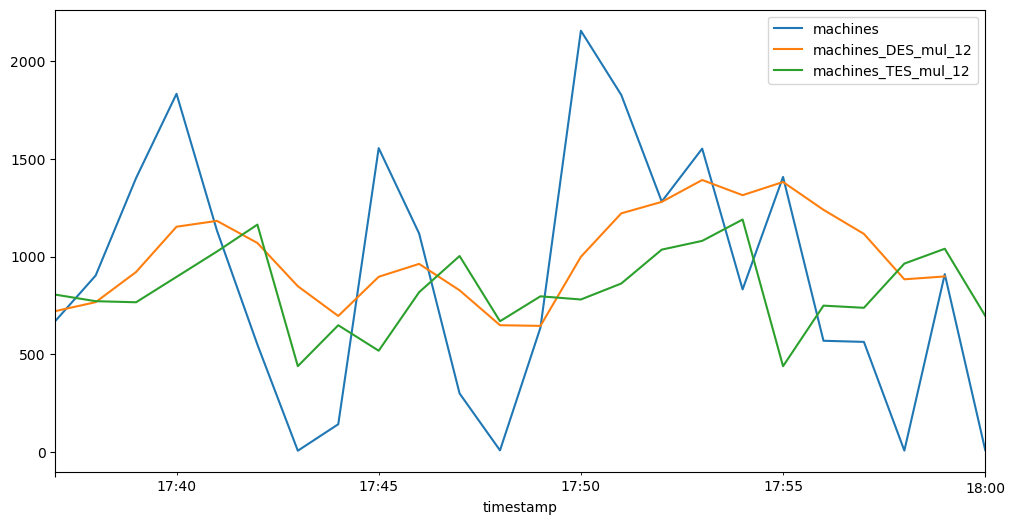

In [129]:
df[['machines','machines_DES_mul_12','machines_TES_mul_12']].iloc[-24:].plot(figsize = (12,6))

<Axes: xlabel='timestamp'>

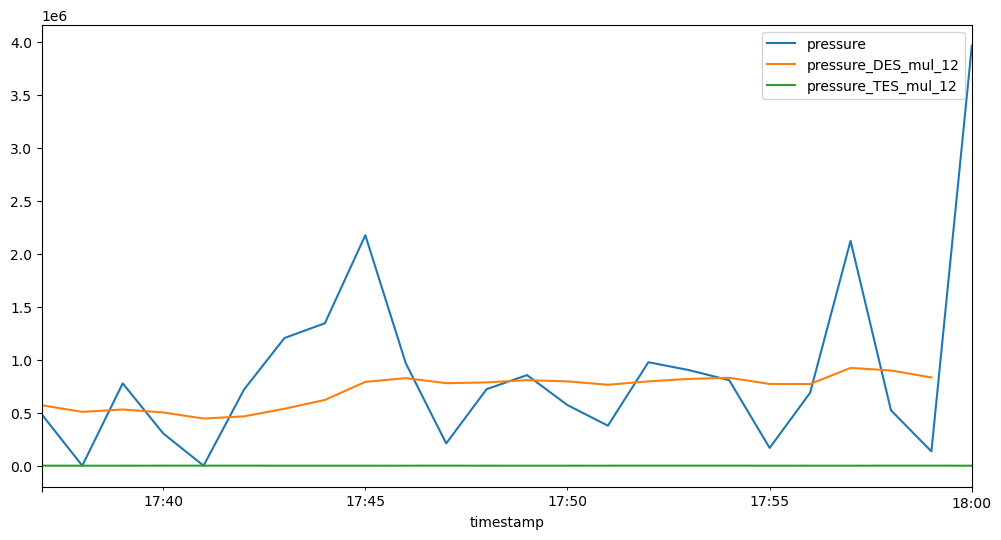

In [130]:
df[['pressure','pressure_DES_mul_12','pressure_TES_mul_12']].iloc[-24:].plot(figsize = (12,6))

## Train-Test Split

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 181 entries, 2023-06-01 15:00:00 to 2023-06-01 18:00:00
Freq: T
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   machines                181 non-null    float64
 1   pressure                181 non-null    float64
 2   machines : 30 Day Mean  152 non-null    float64
 3   pressure : 30 Day Mean  152 non-null    float64
 4   machines trend          181 non-null    float64
 5   pressure trend          181 non-null    float64
 6   machines_6-minute-SMA   176 non-null    float64
 7   pressure_6-minute-SMA   176 non-null    float64
 8   machines_EWMA-12        181 non-null    float64
 9   pressure_EWMA-12        181 non-null    float64
 10  machines_EWMA12         181 non-null    float64
 11  pressure_EWMA12         181 non-null    float64
 12  machines_SES12          180 non-null    float64
 13  pressure_SES12          180 non-null    float64
 1

In [132]:
df = df.iloc[:, :2]

In [133]:
df

machines      pressure
timestamp                                     
2023-06-01 15:00:00   934.785714  1.584936e+06
2023-06-01 15:01:00   418.285714  7.797136e+05
2023-06-01 15:02:00  1022.464286  4.689306e+05
2023-06-01 15:03:00  1316.814815  1.329907e+06
2023-06-01 15:04:00   374.750000  3.090074e+05
...                          ...           ...
2023-06-01 17:56:00   569.500000  6.895071e+05
2023-06-01 17:57:00   563.750000  2.124496e+06
2023-06-01 17:58:00     6.962963  5.239182e+05
2023-06-01 17:59:00   910.785714  1.356822e+05
2023-06-01 18:00:00    10.000000  3.967339e+06

[181 rows x 2 columns]

In [134]:
split_index = int(len(df) * 0.8)
split_index

144

In [135]:
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

## Forecasting Model

### Holt Winters

In [136]:
machines_fitted_model = ExponentialSmoothing(train_data['machines'],
                                    trend = 'mul',
                                    seasonal = 'mul',
                                    seasonal_periods = 12).fit()

C:\Users\Ruman\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [137]:
pressure_fitted_model = ExponentialSmoothing(train_data['pressure'],
                                    trend = 'mul',
                                    seasonal = 'mul',
                                    seasonal_periods = 12).fit()

C:\Users\Ruman\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [138]:
machines_test_predictions = machines_fitted_model.forecast(len(test_data))

In [139]:
pressure_test_predictions = pressure_fitted_model.forecast(len(test_data))

In [140]:
machines_test_predictions

2023-06-01 17:24:00    742.441319
2023-06-01 17:25:00    702.748920
2023-06-01 17:26:00    862.122795
2023-06-01 17:27:00    677.104593
2023-06-01 17:28:00    632.762255
2023-06-01 17:29:00    765.561889
2023-06-01 17:30:00    795.564960
2023-06-01 17:31:00    359.806575
2023-06-01 17:32:00    618.945232
2023-06-01 17:33:00    614.033065
2023-06-01 17:34:00    835.518169
2023-06-01 17:35:00    735.494379
2023-06-01 17:36:00    707.810876
2023-06-01 17:37:00    669.969890
2023-06-01 17:38:00    821.909928
2023-06-01 17:39:00    645.521717
2023-06-01 17:40:00    603.247684
2023-06-01 17:41:00    729.853010
2023-06-01 17:42:00    758.456617
2023-06-01 17:43:00    343.023753
2023-06-01 17:44:00    590.075142
2023-06-01 17:45:00    585.392099
2023-06-01 17:46:00    796.546248
2023-06-01 17:47:00    701.187970
2023-06-01 17:48:00    674.795737
2023-06-01 17:49:00    638.719806
2023-06-01 17:50:00    783.572751
2023-06-01 17:51:00    615.411994
2023-06-01 17:52:00    575.109791
2023-06-01 17:

In [141]:
pressure_test_predictions

2023-06-01 17:24:00    821407.882290
2023-06-01 17:25:00    621480.396936
2023-06-01 17:26:00    665168.092956
2023-06-01 17:27:00    685066.500751
2023-06-01 17:28:00    803066.392111
2023-06-01 17:29:00    794165.479874
2023-06-01 17:30:00    631331.310251
2023-06-01 17:31:00    824454.261159
2023-06-01 17:32:00    796461.952972
2023-06-01 17:33:00    699225.499507
2023-06-01 17:34:00    452813.378505
2023-06-01 17:35:00    798119.550720
2023-06-01 17:36:00    797146.857224
2023-06-01 17:37:00    603124.411057
2023-06-01 17:38:00    645521.751444
2023-06-01 17:39:00    664832.441759
2023-06-01 17:40:00    779347.099554
2023-06-01 17:41:00    770709.083814
2023-06-01 17:42:00    612684.368733
2023-06-01 17:43:00    800103.258537
2023-06-01 17:44:00    772937.728501
2023-06-01 17:45:00    678573.241675
2023-06-01 17:46:00    439439.125636
2023-06-01 17:47:00    774546.367599
2023-06-01 17:48:00    773602.403486
2023-06-01 17:49:00    585310.585831
2023-06-01 17:50:00    626455.682405
2

<Axes: xlabel='timestamp'>

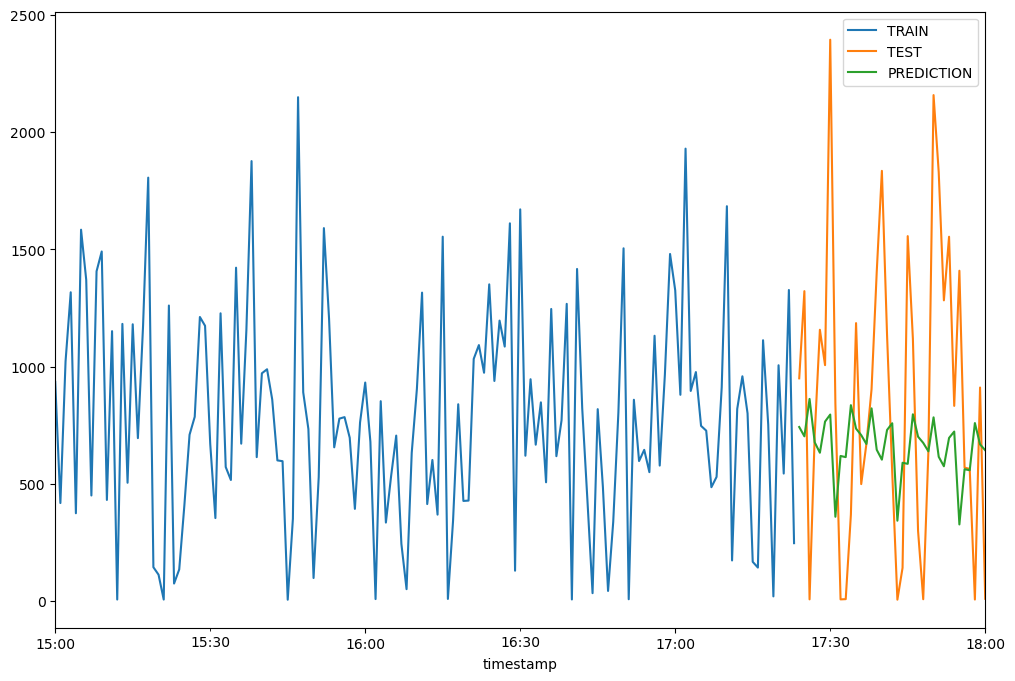

In [142]:
train_data['machines'].plot(legend=True, label = 'TRAIN', figsize = (12,8))
test_data['machines'].plot(legend=True, label = 'TEST')
machines_test_predictions.plot(legend=True,label = 'PREDICTION')

<Axes: xlabel='timestamp'>

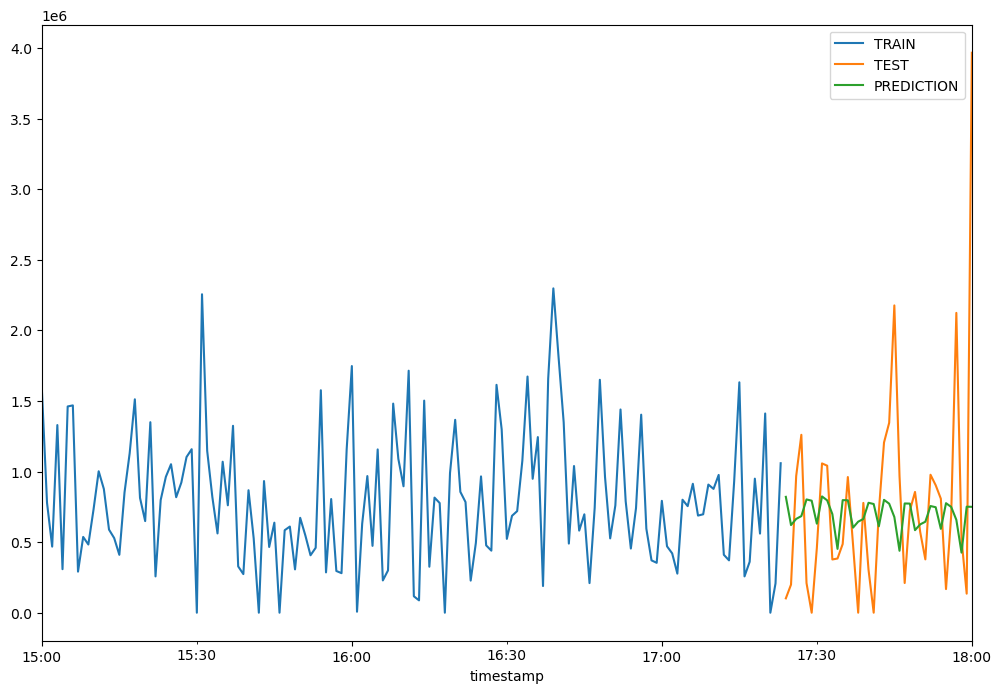

In [143]:
train_data['pressure'].plot(legend=True, label = 'TRAIN', figsize = (12,8))
test_data['pressure'].plot(legend=True, label = 'TEST')
pressure_test_predictions.plot(legend=True,label = 'PREDICTION')

<Axes: xlabel='timestamp'>

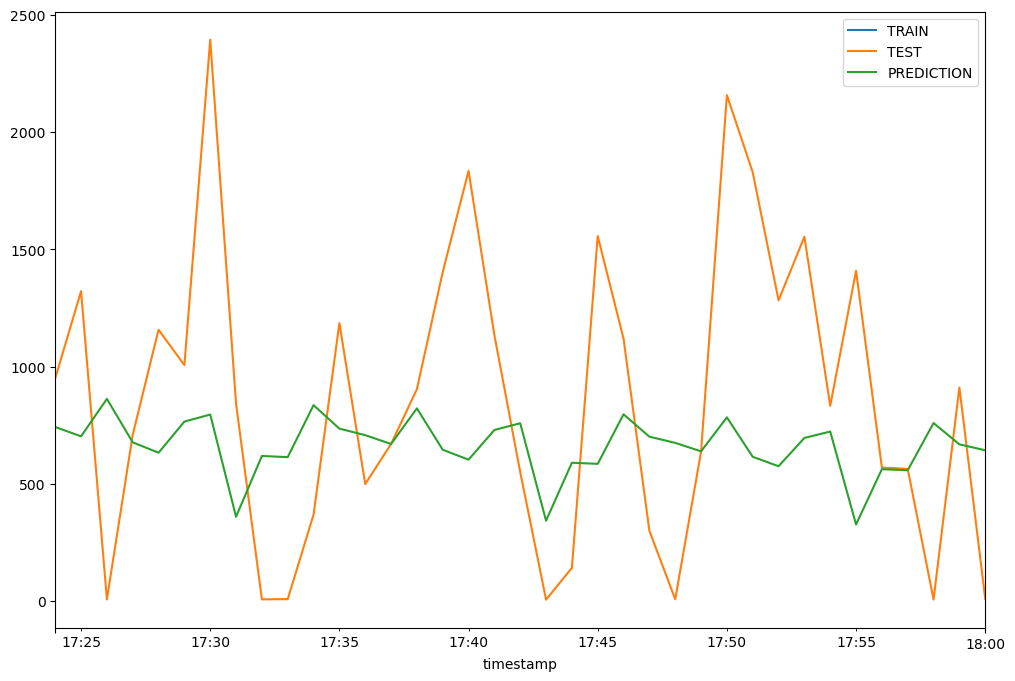

In [144]:
train_data['machines'].plot(legend=True, label = 'TRAIN', figsize = (12,8))
test_data['machines'].plot(legend=True, label = 'TEST')
machines_test_predictions.plot(legend=True,label = 'PREDICTION',xlim = [test_data.index.min(),test_data.index.max()])

<Axes: xlabel='timestamp'>

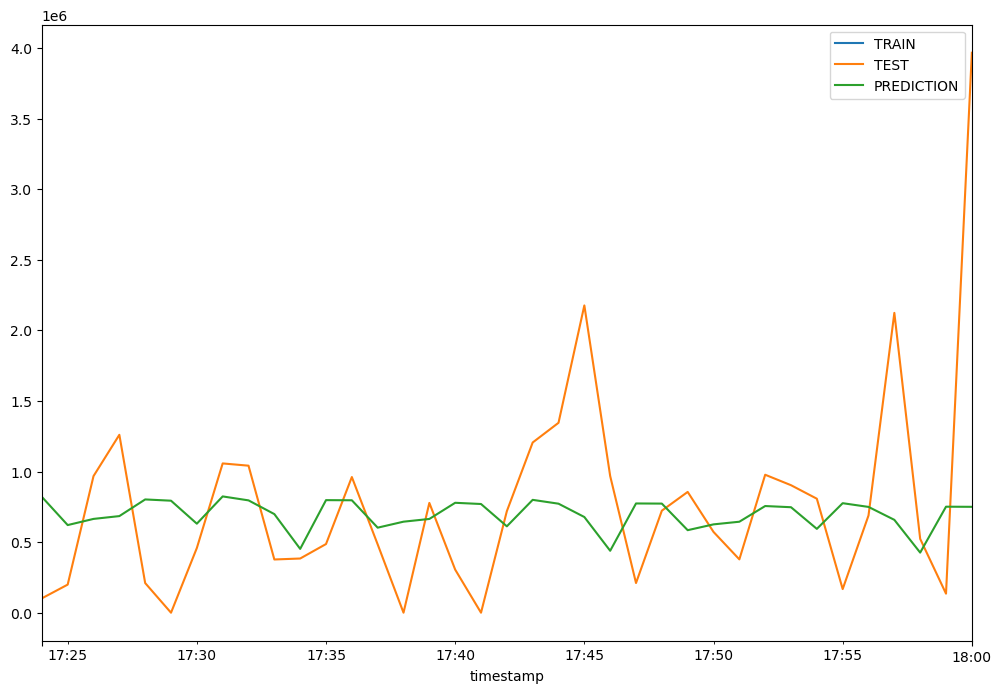

In [145]:
train_data['pressure'].plot(legend=True, label = 'TRAIN', figsize = (12,8))
test_data['pressure'].plot(legend=True, label = 'TEST')
pressure_test_predictions.plot(legend=True,label = 'PREDICTION',xlim = [test_data.index.min(),test_data.index.max()])

## Evaluating Predictions

In [146]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [147]:
test_data.describe()

machines      pressure
count    37.000000  3.700000e+01
mean    860.625125  7.714632e+05
std     643.466634  7.475879e+05
min       6.357143  6.937143e+02
25%     368.928571  3.059466e+05
50%     841.428571  6.895071e+05
75%    1282.392857  9.689572e+05
max    2393.464286  3.967339e+06

In [148]:
mean_absolute_error(test_data['machines'],machines_test_predictions)

532.7937093157649

In [149]:
mean_absolute_error(test_data['pressure'],pressure_test_predictions)

486978.85025965783

In [150]:
mean_squared_error(test_data['machines'],machines_test_predictions)

447299.20637512143

In [151]:
mean_squared_error(test_data['pressure'],pressure_test_predictions)

557060111820.0226

In [152]:
np.sqrt(mean_squared_error(test_data['machines'],machines_test_predictions))

668.8043109722914

In [153]:
np.sqrt(mean_squared_error(test_data['pressure'],pressure_test_predictions))

746364.5971105694

In [154]:
machines_final_model = ExponentialSmoothing(df['machines'],
                                    trend = 'mul',
                                    seasonal = 'mul',
                                    seasonal_periods = 12).fit()

C:\Users\Ruman\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [155]:
pressure_final_model = ExponentialSmoothing(df['pressure'],
                                    trend = 'mul',
                                    seasonal = 'mul',
                                    seasonal_periods = 12).fit()

C:\Users\Ruman\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [156]:
machine_forcast_predictions = machines_final_model.forecast(36)

In [157]:
pressure_forcast_predictions = pressure_final_model.forecast(36)

<Axes: xlabel='timestamp'>

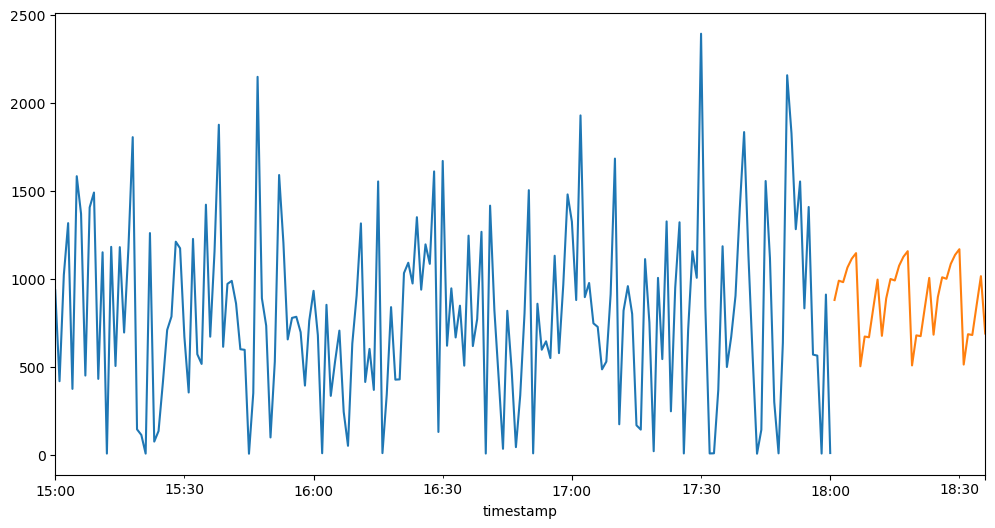

In [158]:
df['machines'].plot(figsize=(12,6))
machine_forcast_predictions.plot()

<Axes: xlabel='timestamp'>

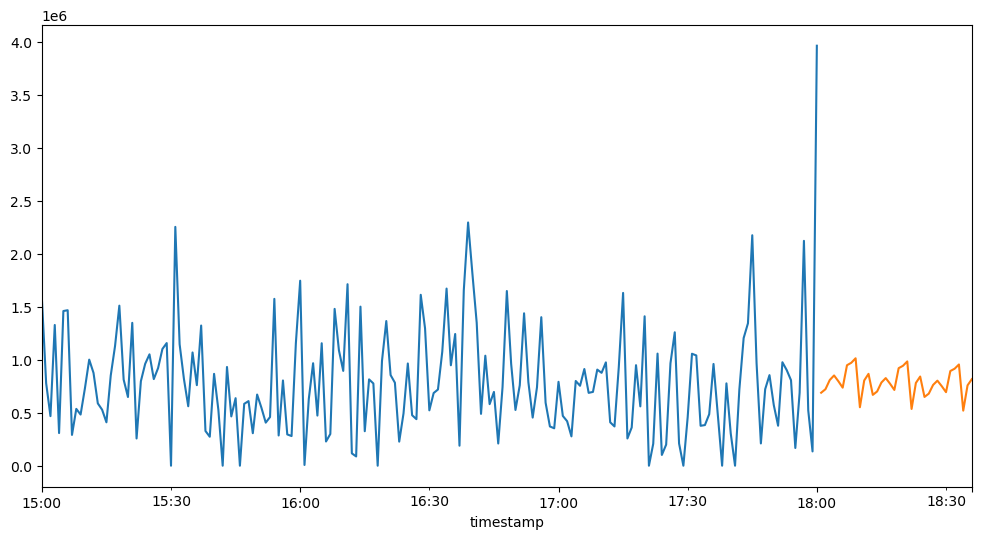

In [159]:
df['pressure'].plot(figsize=(12,6))
pressure_forcast_predictions.plot()

<Axes: >

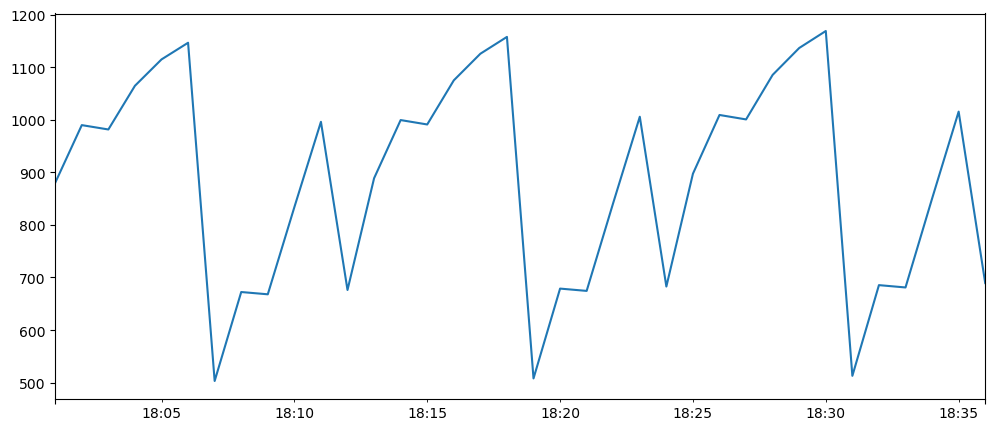

In [160]:
machine_forcast_predictions.plot()

<Axes: >

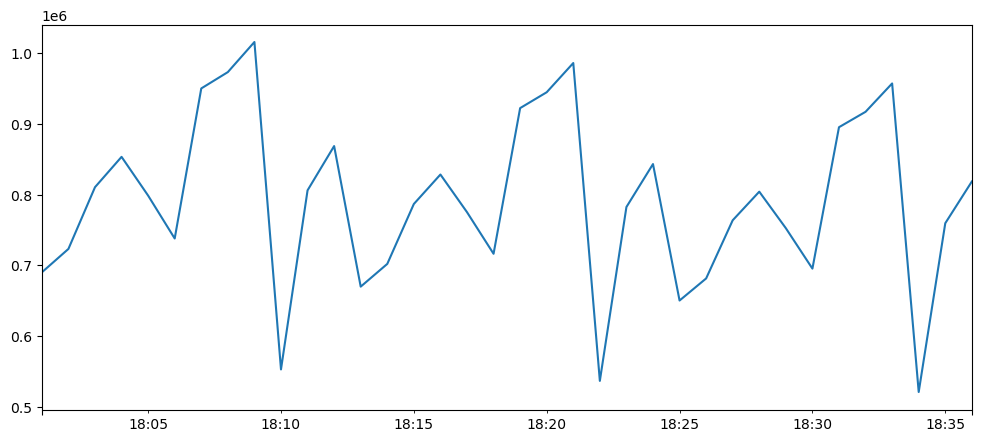

In [161]:
pressure_forcast_predictions.plot()

### Stationary and Non-Stationary Data

In [162]:
from statsmodels.tsa.statespace.tools import diff

<Axes: xlabel='timestamp'>

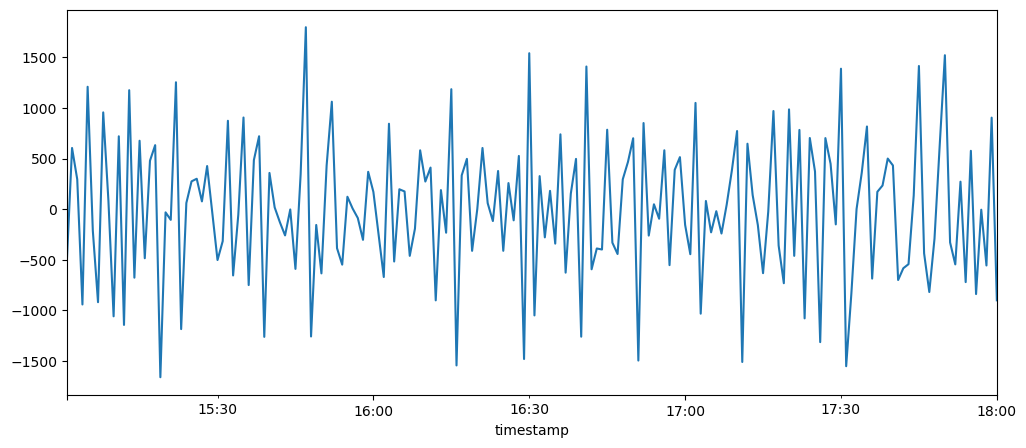

In [163]:
diff(df['machines'],k_diff = 1).plot()

<Axes: xlabel='timestamp'>

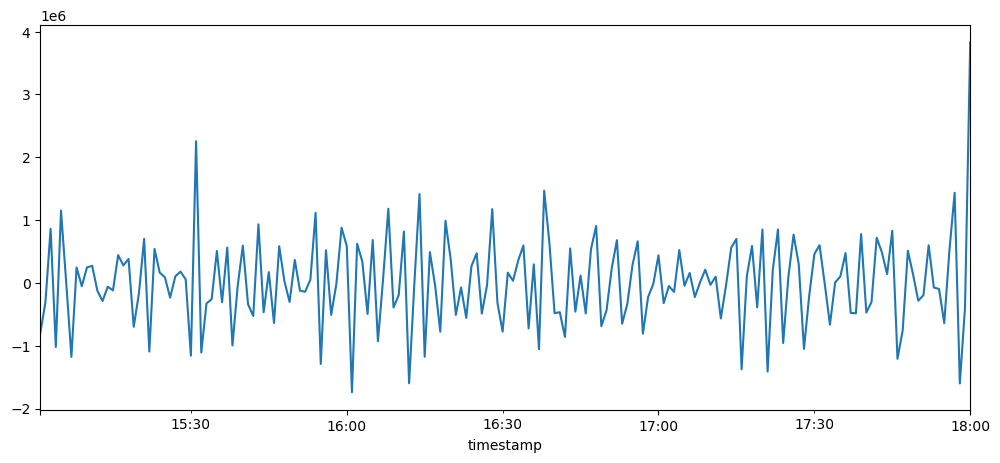

In [164]:
diff(df['pressure'],k_diff = 1).plot()

## ACF and PACF

In [165]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
import warnings
warnings.filterwarnings('ignore')
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

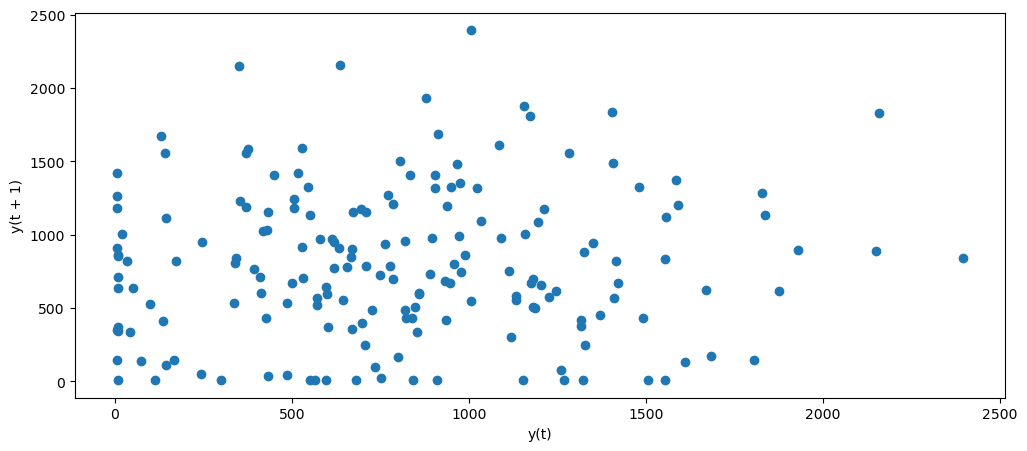

In [166]:
lag_plot(df['machines'])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

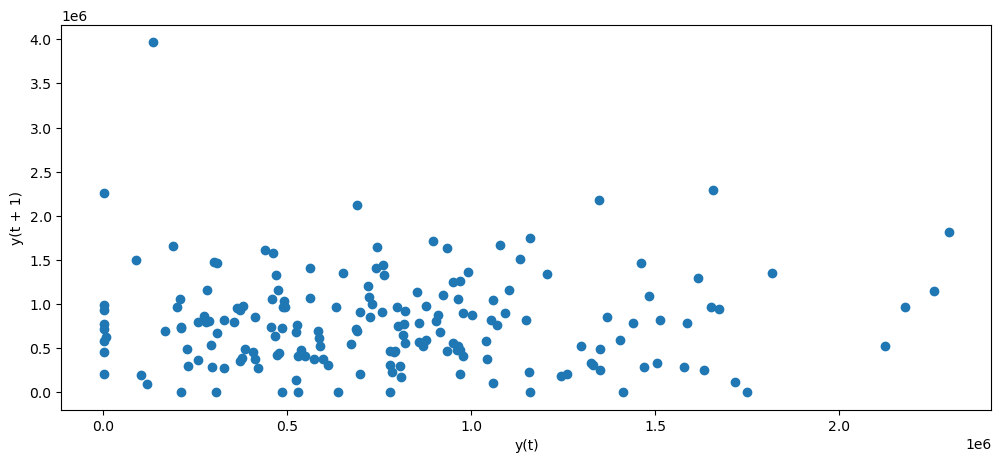

In [167]:
lag_plot(df['pressure'])

In [168]:
acf(df['machines'])

array([ 1.        ,  0.05751595, -0.01241043, -0.03184058,  0.03016316,
        0.04268028, -0.02478129, -0.15256325, -0.10077874, -0.00688766,
        0.09322825,  0.08858878,  0.01448041, -0.04799411, -0.10944401,
        0.02357936, -0.12025529, -0.08160709, -0.10212014, -0.13554441,
        0.04335611, -0.03728751, -0.02388218])

In [169]:
acf(df['pressure'])

array([ 1.00000000e+00,  1.61073049e-02, -1.46292693e-01,  1.49627794e-01,
        3.01790133e-02,  6.59964996e-02,  7.48850641e-02, -9.96468648e-02,
        8.64028703e-02,  6.41997814e-02, -1.03358252e-01,  4.99243034e-02,
        9.70367105e-02, -4.06194778e-02,  4.75716809e-02,  1.76638140e-02,
       -3.89583479e-02,  7.22993754e-02, -1.70478261e-02, -4.34347359e-02,
       -2.58976747e-04, -8.02125985e-02, -7.92246044e-02])

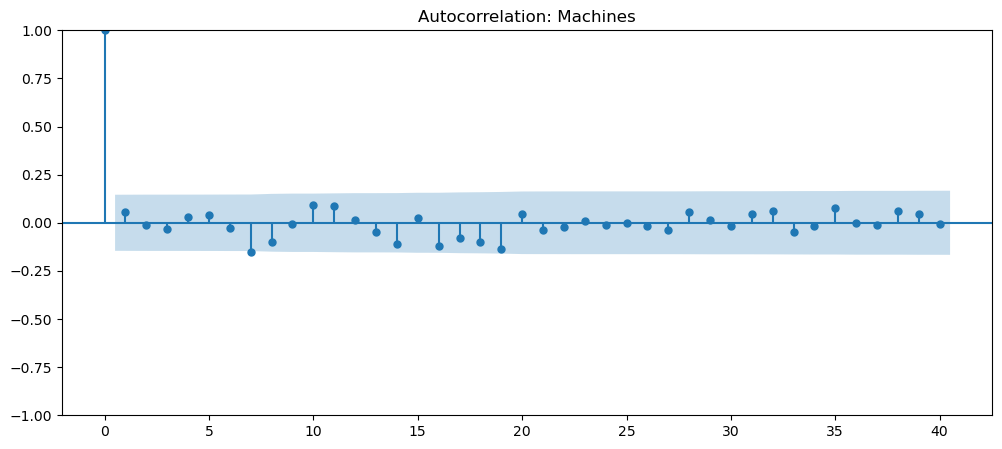

In [170]:
title = 'Autocorrelation: Machines'
lags = 40
plot_acf(df['machines'],title=title,lags=lags);

## PACF Plots


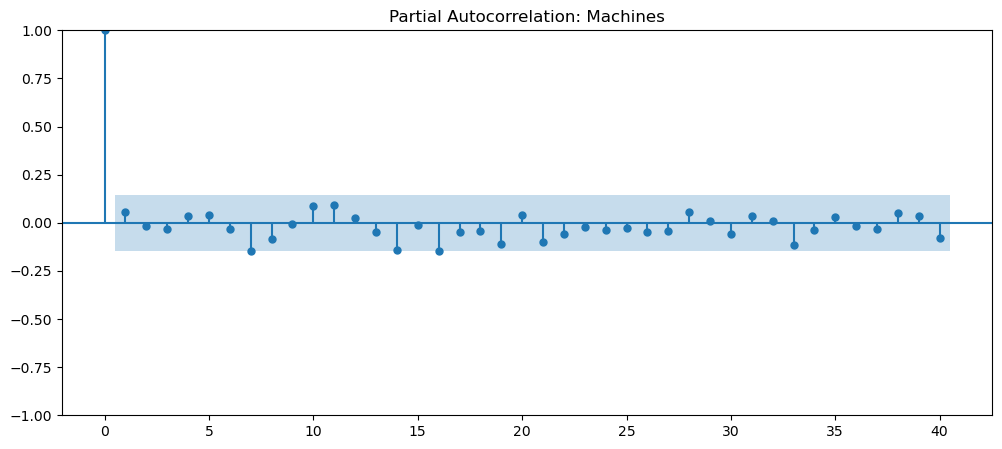

In [171]:
title='Partial Autocorrelation: Machines'
lags=40
plot_pacf(df['machines'],title=title,lags=lags);

### Autoregression AR

In [172]:
split_index = int(len(df) * 0.8)
split_index

144

In [173]:
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

In [174]:
from statsmodels.tsa.ar_model import AutoReg,ARResults

In [175]:
machines_ar_model = AutoReg(train_data['machines'],lags = 1)
pressure_ar_model = AutoReg(train_data['pressure'],lags = 1)

In [176]:
machines_AR1fit = machines_ar_model.fit()
pressure_AR1fit = pressure_ar_model.fit()

In [177]:
machines_AR1fit.aic,pressure_AR1fit.aic

(2172.1695817291047, 4147.070728926047)

In [178]:
machines_AR1fit.params,pressure_AR1fit.params

(const          828.406286
 machines.L1     -0.059746
 dtype: float64,
 const          776858.23381
 pressure.L1         0.01884
 dtype: float64)

In [179]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1

In [180]:
start

144

In [181]:
end

180

In [182]:
machines_AR1fit.predict(start=start,end=end)

2023-06-01 17:24:00    813.633458
2023-06-01 17:25:00    779.794691
2023-06-01 17:26:00    781.816432
2023-06-01 17:27:00    781.695641
2023-06-01 17:28:00    781.702858
2023-06-01 17:29:00    781.702427
2023-06-01 17:30:00    781.702452
2023-06-01 17:31:00    781.702451
2023-06-01 17:32:00    781.702451
2023-06-01 17:33:00    781.702451
2023-06-01 17:34:00    781.702451
2023-06-01 17:35:00    781.702451
2023-06-01 17:36:00    781.702451
2023-06-01 17:37:00    781.702451
2023-06-01 17:38:00    781.702451
2023-06-01 17:39:00    781.702451
2023-06-01 17:40:00    781.702451
2023-06-01 17:41:00    781.702451
2023-06-01 17:42:00    781.702451
2023-06-01 17:43:00    781.702451
2023-06-01 17:44:00    781.702451
2023-06-01 17:45:00    781.702451
2023-06-01 17:46:00    781.702451
2023-06-01 17:47:00    781.702451
2023-06-01 17:48:00    781.702451
2023-06-01 17:49:00    781.702451
2023-06-01 17:50:00    781.702451
2023-06-01 17:51:00    781.702451
2023-06-01 17:52:00    781.702451
2023-06-01 17:

In [183]:
pressure_AR1fit.predict(start=start,end=end)

2023-06-01 17:24:00    796820.080263
2023-06-01 17:25:00    791870.011758
2023-06-01 17:26:00    791776.754408
2023-06-01 17:27:00    791774.997476
2023-06-01 17:28:00    791774.964376
2023-06-01 17:29:00    791774.963752
2023-06-01 17:30:00    791774.963740
2023-06-01 17:31:00    791774.963740
2023-06-01 17:32:00    791774.963740
2023-06-01 17:33:00    791774.963740
2023-06-01 17:34:00    791774.963740
2023-06-01 17:35:00    791774.963740
2023-06-01 17:36:00    791774.963740
2023-06-01 17:37:00    791774.963740
2023-06-01 17:38:00    791774.963740
2023-06-01 17:39:00    791774.963740
2023-06-01 17:40:00    791774.963740
2023-06-01 17:41:00    791774.963740
2023-06-01 17:42:00    791774.963740
2023-06-01 17:43:00    791774.963740
2023-06-01 17:44:00    791774.963740
2023-06-01 17:45:00    791774.963740
2023-06-01 17:46:00    791774.963740
2023-06-01 17:47:00    791774.963740
2023-06-01 17:48:00    791774.963740
2023-06-01 17:49:00    791774.963740
2023-06-01 17:50:00    791774.963740
2

In [184]:
test_data

machines      pressure
timestamp                                     
2023-06-01 17:24:00   949.892857  1.024012e+05
2023-06-01 17:25:00  1321.642857  1.997161e+05
2023-06-01 17:26:00     7.678571  9.683258e+05
2023-06-01 17:27:00   709.357143  1.260928e+06
2023-06-01 17:28:00  1156.962963  2.107756e+05
2023-06-01 17:29:00  1006.142857  6.937143e+02
2023-06-01 17:30:00  2393.464286  4.590627e+05
2023-06-01 17:31:00   841.428571  1.058145e+06
2023-06-01 17:32:00     7.592593  1.042180e+06
2023-06-01 17:33:00     8.607143  3.777140e+05
2023-06-01 17:34:00   368.928571  3.846305e+05
2023-06-01 17:35:00  1185.357143  4.871000e+05
2023-06-01 17:36:00   499.071429  9.617058e+05
2023-06-01 17:37:00   670.111111  4.845941e+05
2023-06-01 17:38:00   903.607143  8.188571e+02
2023-06-01 17:39:00  1403.071429  7.784264e+05
2023-06-01 17:40:00  1834.428571  3.059466e+05
2023-06-01 17:41:00  1133.925926  7.821481e+02
2023-06-01 17:42:00   550.000000  7.198641e+05
2023-06-01 17:43:00     6.357143  1.206424e+06
2023-06-01 17:44:00   142.035714  1.345915e+06
2023-06-01 17:45:00  1556.148148  2.177413e+06
2023-06-01 17:46:00  1118.750000  9.689572e+05
2023-06-01 17:47:00   299.857143  2.110392e+05
2023-06-01 17:48:00     8.178571  7.235829e+05
2023-06-01 17:49:00   636.785714  8.563015e+05
2023-06-01 17:50:00  2157.407407  5.730079e+05
2023-06-01 17:51:00  1828.214286  3.785541e+05
2023-06-01 17:52:00  1282.392857  9.779825e+05
2023-06-01 17:53:00  1553.571429  9.038884e+05
2023-06-01 17:54:00   832.518519  8.081794e+05
2023-06-01 17:55:00  1408.642857  1.681405e+05
2023-06-01 17:56:00   569.500000  6.895071e+05
2023-06-01 17:57:00   563.750000  2.124496e+06
2023-06-01 17:58:00     6.962963  5.239182e+05
2023-06-01 17:59:00   910.785714  1.356822e+05
2023-06-01 18:00:00    10.000000  3.967339e+06

In [185]:
machines_predictions1 = machines_AR1fit.predict(start=start,end=end)
pressure_predictions1 = pressure_AR1fit.predict(start=start,end=end)

In [186]:
machines_predictions1 = machines_predictions1.rename('machines AR(1) Predictions')
pressure_predictions1 = pressure_predictions1.rename('pressure AR(1) Predictions')

<Axes: xlabel='timestamp'>

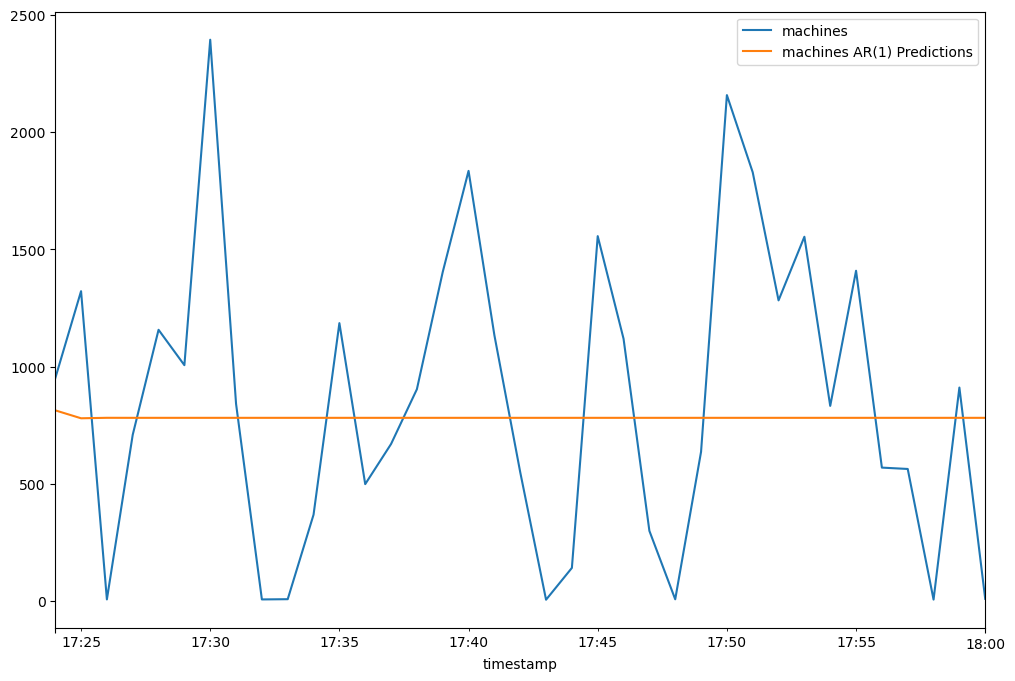

In [187]:
test_data['machines'].plot(figsize = (12,8),legend = True)
machines_predictions1.plot(legend = True)

<Axes: xlabel='timestamp'>

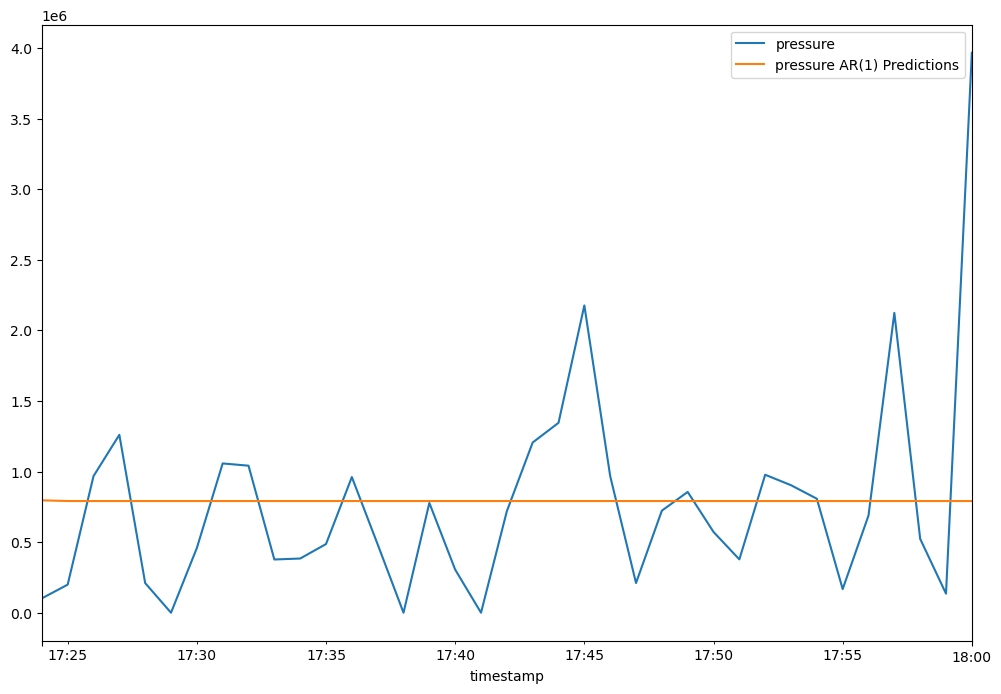

In [188]:
test_data['pressure'].plot(figsize = (12,8),legend = True)
pressure_predictions1.plot(legend = True)

In [189]:
machines_ar_model_1 = AutoReg(train_data['machines'],lags = 2)
pressure_ar_model_1 = AutoReg(train_data['pressure'],lags = 2)

In [190]:
machines_AR2fit = machines_ar_model_1.fit()
pressure_AR2fit = pressure_ar_model_1.fit()

In [191]:
machines_AR2fit.params,pressure_AR2fit.params

(const          808.822766
 machines.L1     -0.056790
 machines.L2      0.025251
 dtype: float64,
 const          873210.970348
 pressure.L1         0.022524
 pressure.L2        -0.123894
 dtype: float64)

In [192]:
machines_predictions2 = machines_AR2fit.predict(start,end)
pressure_predictions2 = pressure_AR2fit.predict(start,end)

In [193]:
machines_predictions2 = machines_predictions2.rename('machines_AR(2) Predictions')
pressure_predictions2 = pressure_predictions2.rename('pressure_AR(2) Predictions')

<Axes: xlabel='timestamp'>

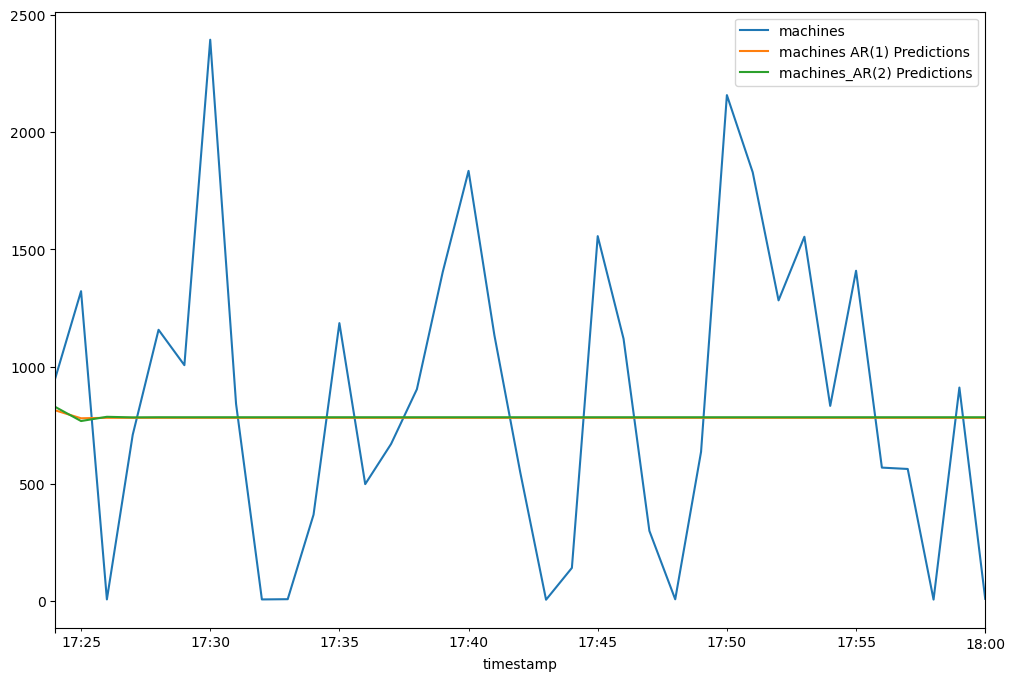

In [194]:
test_data['machines'].plot(figsize = (12,8),legend = True)
machines_predictions1.plot(legend = True)
machines_predictions2.plot(legend = True)

<Axes: xlabel='timestamp'>

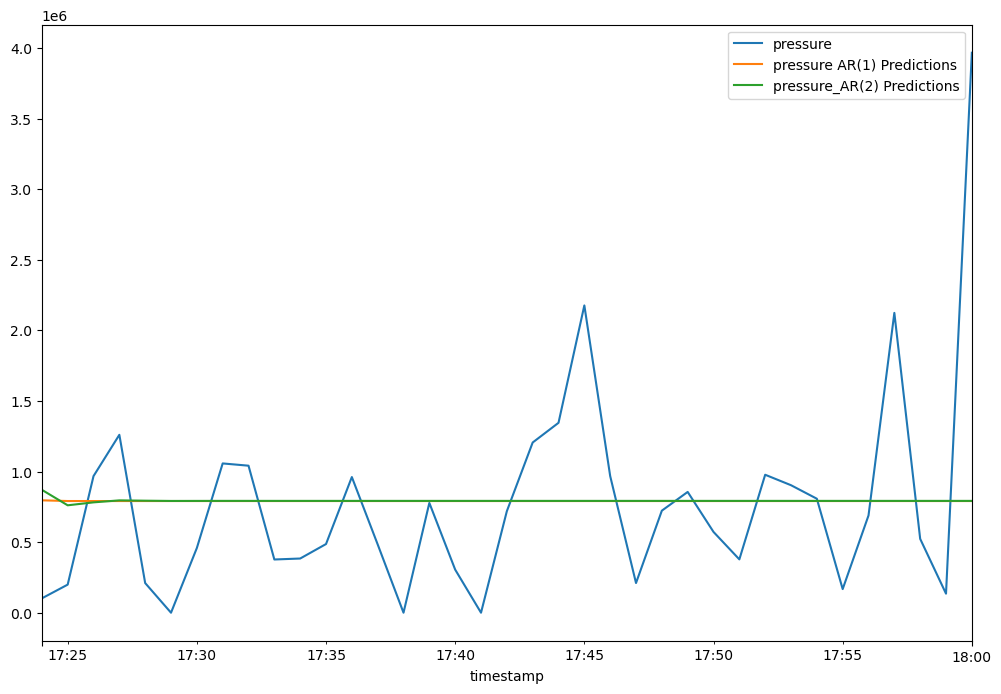

In [195]:
test_data['pressure'].plot(figsize = (12,8),legend = True)
pressure_predictions1.plot(legend = True)
pressure_predictions2.plot(legend = True)

In [196]:
# Define a range of lags to test
lag_range = range(1, 11)  # Example: testing lags from 1 to 10

# Store results
results = []

for lags in lag_range:
    # Create and fit the model
    machines_ar_model_2 = AutoReg(train_data['machines'], lags=lags)
    machines_ARfit = machines_ar_model_2.fit()

    # Extract coefficients and standard errors
    machines_coefficients = machines_ARfit.params
    machines_standard_errors = machines_ARfit.bse

    # Calculate t-statistics
    machines_t_statistics = machines_coefficients / machines_standard_errors

    # Collect information
    results.append({
        'lags': lags,
        't_statistics': machines_t_statistics,
        'aic': machines_ARfit.aic,
        'bic': machines_ARfit.bic
    })

# Convert results to DataFrame for easier inspection
machines_results_df = pd.DataFrame(results)

### Best lags = 10

for index, row in machines_results_df.iterrows():
    print(f"\nLag {row['lags']} - AIC: {row['aic']}, BIC: {row['bic']}")
    print("T-Statistics:")
    print(row['t_statistics'])


Lag 1 - AIC: 2172.1695817291047, BIC: 2181.0581156198846
T-Statistics:
const          10.788804
machines.L1    -0.712745
dtype: float64

Lag 2 - AIC: 2159.361585613559, BIC: 2171.184893843964
T-Statistics:
const          7.808076
machines.L1   -0.675556
machines.L2    0.299080
dtype: float64

Lag 3 - AIC: 2146.1990871258454, BIC: 2160.9428865777363
T-Statistics:
const          6.011461
machines.L1   -0.664234
machines.L2    0.328806
machines.L3    0.896779
dtype: float64

Lag 4 - AIC: 2129.9589757291565, BIC: 2147.6088302648122
T-Statistics:
const          4.643425
machines.L1   -0.845195
machines.L2    0.368601
machines.L3    0.954859
machines.L4    1.660184
dtype: float64

Lag 5 - AIC: 2117.19987349725, BIC: 2137.741191029165
T-Statistics:
const          4.306534
machines.L1   -0.751733
machines.L2    0.404828
machines.L3    0.900316
machines.L4    1.666250
machines.L5   -0.039616
dtype: float64

Lag 6 - AIC: 2102.0859564056454, BIC: 2125.503985886903
T-Statistics:
const          4.

In [197]:
# Define a range of lags to test
lag_range = range(1, 51)  # Example: testing lags from 1 to 10

# Store results
results = []

for lags in lag_range:
    # Create and fit the model
    pressure_ar_model_2 = AutoReg(train_data['pressure'], lags=lags)
    pressure_ARfit = pressure_ar_model_2.fit()

    # Extract coefficients and standard errors
    pressure_coefficients = pressure_ARfit.params
    pressure_standard_errors = pressure_ARfit.bse

    # Calculate t-statistics
    pressure_t_statistics = pressure_coefficients / pressure_standard_errors

    # Collect information
    results.append({
        'lags': lags,
        't_statistics': pressure_t_statistics,
        'aic': pressure_ARfit.aic,
        'bic': pressure_ARfit.bic
    })

# Convert results to DataFrame for easier inspection
pressure_results_df = pd.DataFrame(results)

### Best lags = 44

for index, row in pressure_results_df.iterrows():
    print(f"\nLag {row['lags']} - AIC: {row['aic']}, BIC: {row['bic']}")
    print("T-Statistics:")
    print(row['t_statistics'])


Lag 1 - AIC: 4147.070728926047, BIC: 4155.959262816827
T-Statistics:
const          10.120897
pressure.L1     0.227302
dtype: float64

Lag 2 - AIC: 4118.894606449882, BIC: 4130.717914680287
T-Statistics:
const          8.700038
pressure.L1    0.270164
pressure.L2   -1.492653
dtype: float64

Lag 3 - AIC: 4091.192957569606, BIC: 4105.936757021496
T-Statistics:
const          6.220331
pressure.L1    0.412567
pressure.L2   -1.428748
pressure.L3    1.232578
dtype: float64

Lag 4 - AIC: 4064.2301000955385, BIC: 4081.8799546311943
T-Statistics:
const          5.522885
pressure.L1    0.453213
pressure.L2   -1.418659
pressure.L3    1.085431
pressure.L4   -0.014596
dtype: float64

Lag 5 - AIC: 4031.0027540883148, BIC: 4051.5440716202297
T-Statistics:
const          3.986548
pressure.L1    0.564294
pressure.L2   -1.732839
pressure.L3    1.394724
pressure.L4    0.032651
pressure.L5    2.455786
dtype: float64

Lag 6 - AIC: 3999.7927351930116, BIC: 4023.2107646742693
T-Statistics:
const          3.

In [198]:
machines_ar_model_2 = AutoReg(train_data['machines'], lags=10)
machines_ARfit = machines_ar_model_2.fit()

In [199]:
pressure_ar_model_2 = AutoReg(train_data['pressure'], lags=10)
pressure_ARfit = pressure_ar_model_2.fit()

In [200]:
machines_ARfit.params,pressure_ARfit.params

(const           721.213085
 machines.L1      -0.070995
 machines.L2       0.039870
 machines.L3       0.040282
 machines.L4       0.157782
 machines.L5       0.000058
 machines.L6      -0.042073
 machines.L7      -0.089901
 machines.L8      -0.052391
 machines.L9       0.063845
 machines.L10      0.009132
 dtype: float64,
 const           557058.048848
 pressure.L1          0.053448
 pressure.L2         -0.112251
 pressure.L3          0.073178
 pressure.L4          0.067748
 pressure.L5          0.147402
 pressure.L6          0.163604
 pressure.L7         -0.155395
 pressure.L8          0.088901
 pressure.L9          0.046842
 pressure.L10        -0.077684
 dtype: float64)

In [201]:
machines_predictions10 = machines_ARfit.predict(start,end)
machines_predictions10 = machines_predictions10.rename('machines AR(10) predictions')

In [202]:
pressure_predictions10 = pressure_ARfit.predict(start,end)
pressure_predictions10 = pressure_predictions10.rename('pressure AR(10) predictions')

In [232]:
machines_ar_model_3 = AutoReg(train_data['machines'], lags=44)
machines_ARfit_44 = machines_ar_model_3.fit()

In [233]:
pressure_ar_model_3 = AutoReg(train_data['pressure'], lags=44)
pressure_ARfit_44 = pressure_ar_model_3.fit()

In [234]:
machines_ARfit_44.params,pressure_ARfit_44.params

(const           2393.410951
 machines.L1       -0.124531
 machines.L2        0.030336
 machines.L3       -0.088314
 machines.L4        0.182739
 machines.L5        0.036798
 machines.L6       -0.051951
 machines.L7       -0.169715
 machines.L8       -0.137741
 machines.L9       -0.036673
 machines.L10      -0.039595
 machines.L11       0.058097
 machines.L12       0.064564
 machines.L13      -0.094374
 machines.L14      -0.147910
 machines.L15      -0.100784
 machines.L16      -0.278040
 machines.L17      -0.109377
 machines.L18       0.087765
 machines.L19      -0.072212
 machines.L20       0.006570
 machines.L21      -0.124124
 machines.L22      -0.118073
 machines.L23      -0.062655
 machines.L24      -0.086368
 machines.L25      -0.084109
 machines.L26      -0.119726
 machines.L27      -0.162478
 machines.L28       0.036358
 machines.L29      -0.154547
 machines.L30      -0.101502
 machines.L31       0.153814
 machines.L32      -0.029775
 machines.L33      -0.172297
 machines.L34 

In [235]:
machines_predictions44 = machines_ARfit.predict(start,end)
machines_predictions44 = machines_predictions44.rename('machines AR(44) predictions')

In [236]:
pressure_predictions44 = pressure_ARfit.predict(start,end)
pressure_predictions44 = pressure_predictions44.rename('pressure AR(44) predictions')

In [237]:
labels = ['AR1','AR2','AR10','AR44']

In [238]:
machines_preds = [machines_predictions1,machines_predictions2,machines_predictions10,machines_predictions44]
pressure_preds = [pressure_predictions1,pressure_predictions2,pressure_predictions10,pressure_predictions44]

In [240]:
for i in range(4):
    #np.sqrt()
    error = mean_squared_error(test_data['machines'],machines_preds[i])
    print(f'{labels[i]} MSE was "{error}')

AR1 MSE was "408885.34873313806
AR2 MSE was "408927.9278535923
AR10 MSE was "417152.63579066226
AR44 MSE was "391716.21098082885


In [241]:
for i in range(4):
    #np.sqrt()
    error = mean_squared_error(test_data['pressure'],pressure_preds[i])
    print(f'{labels[i]} MSE was "{error}')

AR1 MSE was "544386894045.4191
AR2 MSE was "546388177820.1498
AR10 MSE was "557280369653.2948
AR44 MSE was "640099820732.7621


<Axes: xlabel='timestamp'>

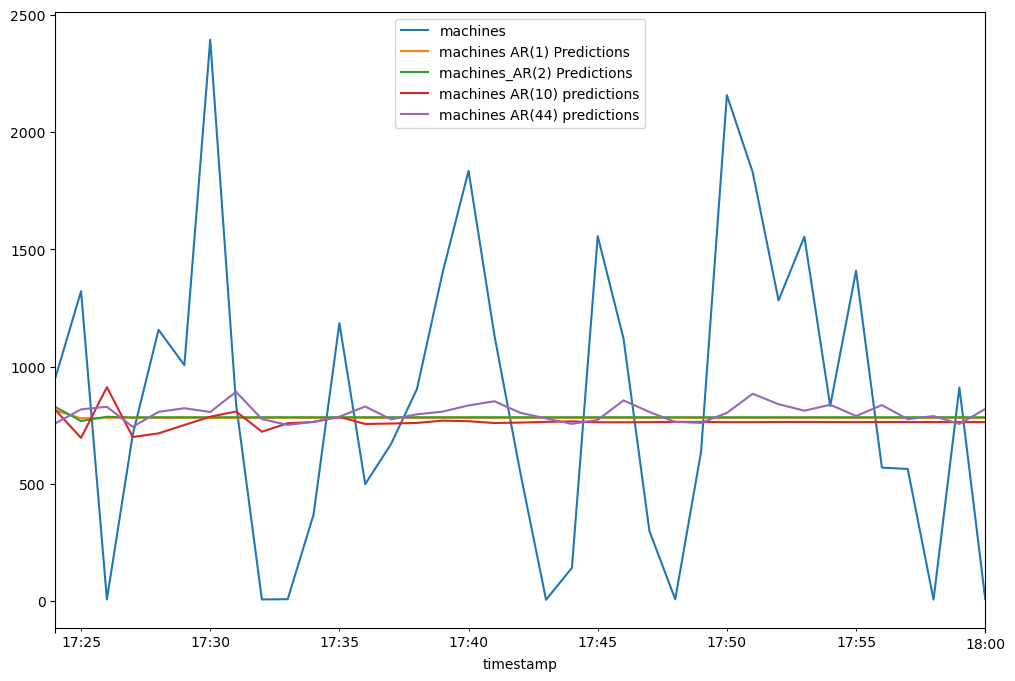

In [242]:
test_data['machines'].plot(figsize=(12,8),legend= True)
machines_predictions1.plot(legend = True)
machines_predictions2.plot(legend = True)
machines_predictions10.plot(legend=True)
machines_predictions44.plot(legend=True)

<Axes: xlabel='timestamp'>

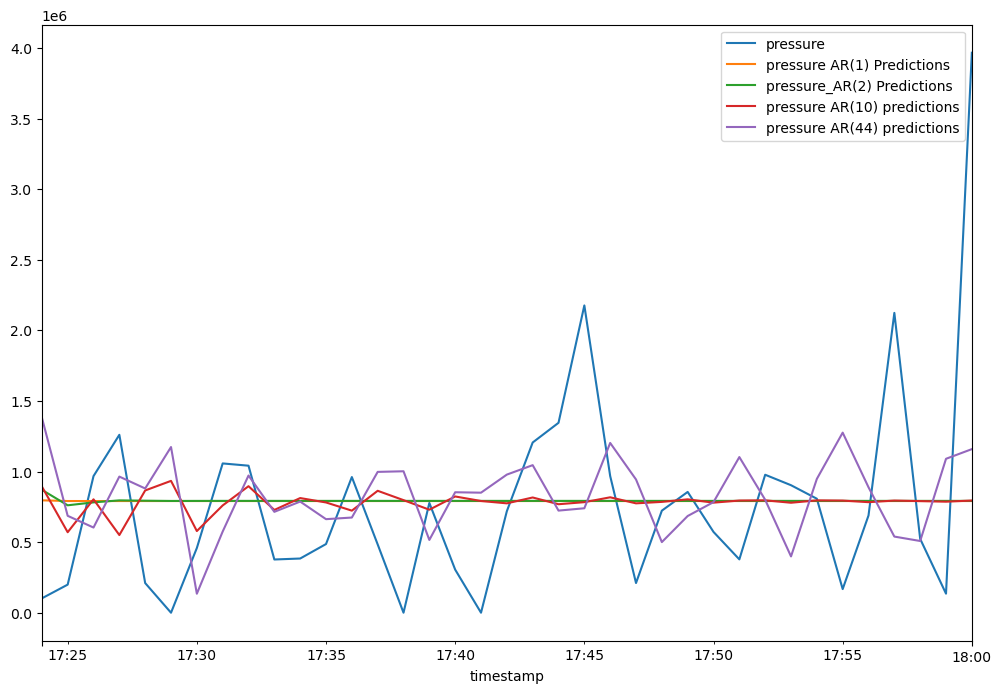

In [244]:
test_data['pressure'].plot(figsize=(12,8),legend= True)
pressure_predictions1.plot(legend = True)
pressure_predictions2.plot(legend = True)
pressure_predictions10.plot(legend=True)
pressure_predictions44.plot(legend=True)

### Final AR Model

In [245]:
# Forcasting Future

machines_final_model = AutoReg(df['machines'],lags = 44)

machines_ARfit = machines_final_model.fit()

machines_forcasted_values = machines_ARfit.predict(start = len(df), end = len(df) + 36).rename('Forecast')

<Axes: xlabel='timestamp'>

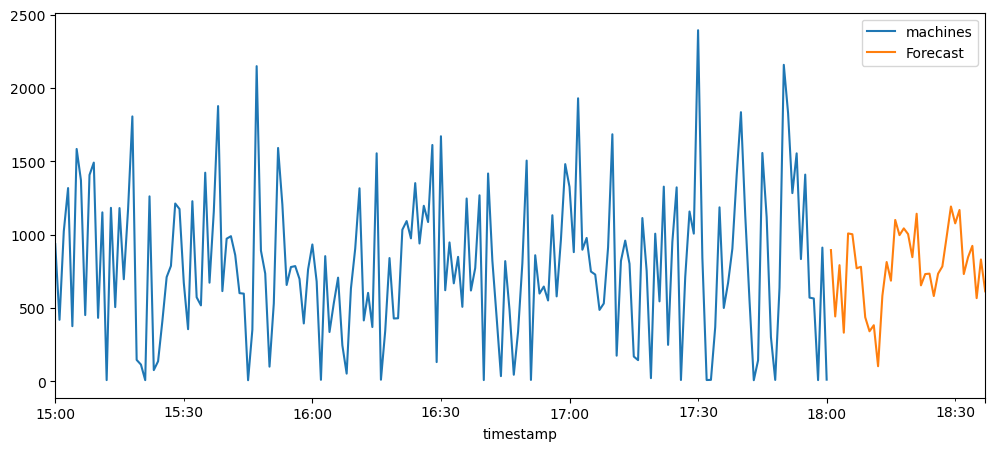

In [246]:
df['machines'].plot(legend = True)
machines_forcasted_values.plot(legend = True)

## RNN

In [247]:
df

machines      pressure
timestamp                                     
2023-06-01 15:00:00   934.785714  1.584936e+06
2023-06-01 15:01:00   418.285714  7.797136e+05
2023-06-01 15:02:00  1022.464286  4.689306e+05
2023-06-01 15:03:00  1316.814815  1.329907e+06
2023-06-01 15:04:00   374.750000  3.090074e+05
...                          ...           ...
2023-06-01 17:56:00   569.500000  6.895071e+05
2023-06-01 17:57:00   563.750000  2.124496e+06
2023-06-01 17:58:00     6.962963  5.239182e+05
2023-06-01 17:59:00   910.785714  1.356822e+05
2023-06-01 18:00:00    10.000000  3.967339e+06

[181 rows x 2 columns]

In [248]:
df.tail()

machines      pressure
timestamp                                    
2023-06-01 17:56:00  569.500000  6.895071e+05
2023-06-01 17:57:00  563.750000  2.124496e+06
2023-06-01 17:58:00    6.962963  5.239182e+05
2023-06-01 17:59:00  910.785714  1.356822e+05
2023-06-01 18:00:00   10.000000  3.967339e+06

In [249]:
len(df)

181

In [923]:
181 - 12

169

In [1208]:
machine_DF = df.copy()
machine_DF = machine_DF.drop('pressure',axis=1)

In [1209]:
machine_DF

machines
timestamp                       
2023-06-01 15:00:00   934.785714
2023-06-01 15:01:00   418.285714
2023-06-01 15:02:00  1022.464286
2023-06-01 15:03:00  1316.814815
2023-06-01 15:04:00   374.750000
...                          ...
2023-06-01 17:56:00   569.500000
2023-06-01 17:57:00   563.750000
2023-06-01 17:58:00     6.962963
2023-06-01 17:59:00   910.785714
2023-06-01 18:00:00    10.000000

[181 rows x 1 columns]

In [1210]:
# split_index = int(len(df) * 0.8)
# split_index
train = machine_DF.iloc[:169]
test = machine_DF.iloc[169:]

In [1211]:
from sklearn.preprocessing import MinMaxScaler

In [1212]:
scaler = MinMaxScaler()

In [1213]:
scaler.fit(train)

MinMaxScaler()

In [1214]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [1215]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [1216]:
scaled_train

array([[3.88989453e-01],
       [1.72638193e-01],
       [4.25716209e-01],
       [5.49013611e-01],
       [1.54401975e-01],
       [6.60767447e-01],
       [5.71276834e-01],
       [1.86124340e-01],
       [5.86461216e-01],
       [6.21826614e-01],
       [1.78188346e-01],
       [4.79587104e-01],
       [3.59039569e-04],
       [4.92557409e-01],
       [2.08871269e-01],
       [4.91854290e-01],
       [2.88563648e-01],
       [4.88907173e-01],
       [7.53728776e-01],
       [5.80596903e-02],
       [4.46982101e-02],
       [3.14159623e-04],
       [5.25349690e-01],
       [2.88727654e-02],
       [5.40803351e-02],
       [1.68950280e-01],
       [2.94651806e-01],
       [3.26606328e-01],
       [5.04869474e-01],
       [4.89160385e-01],
       [2.78420226e-01],
       [1.45814945e-01],
       [5.11451866e-01],
       [2.36951156e-01],
       [2.13785900e-01],
       [5.92923928e-01],
       [2.78674546e-01],
       [4.81711422e-01],
       [7.83260334e-01],
       [2.54603934e-01],


In [1217]:
# define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [1218]:
len(scaled_train)

169

In [1219]:
len(generator) # n_input = 2

167

In [1220]:
scaled_train

array([[3.88989453e-01],
       [1.72638193e-01],
       [4.25716209e-01],
       [5.49013611e-01],
       [1.54401975e-01],
       [6.60767447e-01],
       [5.71276834e-01],
       [1.86124340e-01],
       [5.86461216e-01],
       [6.21826614e-01],
       [1.78188346e-01],
       [4.79587104e-01],
       [3.59039569e-04],
       [4.92557409e-01],
       [2.08871269e-01],
       [4.91854290e-01],
       [2.88563648e-01],
       [4.88907173e-01],
       [7.53728776e-01],
       [5.80596903e-02],
       [4.46982101e-02],
       [3.14159623e-04],
       [5.25349690e-01],
       [2.88727654e-02],
       [5.40803351e-02],
       [1.68950280e-01],
       [2.94651806e-01],
       [3.26606328e-01],
       [5.04869474e-01],
       [4.89160385e-01],
       [2.78420226e-01],
       [1.45814945e-01],
       [5.11451866e-01],
       [2.36951156e-01],
       [2.13785900e-01],
       [5.92923928e-01],
       [2.78674546e-01],
       [4.81711422e-01],
       [7.83260334e-01],
       [2.54603934e-01],


In [1221]:
# What does the first batch look like?
X,y = generator[0]

In [1222]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.38898945 0.17263819]
Predict this y: 
 [[0.42571621]]


In [1285]:
# Let's redefine to get 12 months back and then predict the next month out
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [1286]:
# What does the first batch look like?
X,y = generator[0]

In [1287]:
# # Split training data into training and validation sets
# train_size = int(len(scaled_train) * 0.8)
# val_data = scaled_train[train_size:]
# train_data = scaled_train[:train_size]

# train_generator = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=1)
# val_generator = TimeseriesGenerator(val_data, val_data, length=n_input, batch_size=1)

In [1288]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam


In [1289]:
# define model
model = Sequential()
model.add(LSTM(25, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
# model.add(LSTM(25, return_sequences=True))
# model.add(LSTM(25, return_sequences=True))
# model.add(LSTM(25, return_sequences=True))

model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [1290]:
model.summary()

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_88 (LSTM)                       │ (None, 12, 25)              │           2,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 12, 1)               │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,726 (10.65 KB)

 Trainable params: 2,726 (10.65 KB)

 Non-trainable params: 0 (0.00 B)

In [1291]:
# from keras.callbacks import EarlyStopping

# # Define EarlyStopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Monitor validation loss
#     patience=12,          # Stop after 5 epochs with no improvement
#     restore_best_weights=True  # Restore the best weights
# )
# fit model
# model.fit(
#     train_generator,
#     epochs=100,  # Set a large number of epochs
#     validation_data=val_generator,
#     callbacks=[early_stopping]
# )


In [1292]:
# fit model
model.fit(generator,epochs=40)

Epoch 1/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1141
Epoch 2/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0487
Epoch 3/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0550
Epoch 4/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0405
Epoch 5/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0413
Epoch 6/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0361
Epoch 7/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0421
Epoch 8/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0474
Epoch 9/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0440
Epoch 10/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0478
Epoch 11/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0476
Epoch 12/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0414
Epoch 13/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0442
Epoch 14/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0452
Epoch 15/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

In [1293]:
model.history.history.keys()

dict_keys(['loss'])

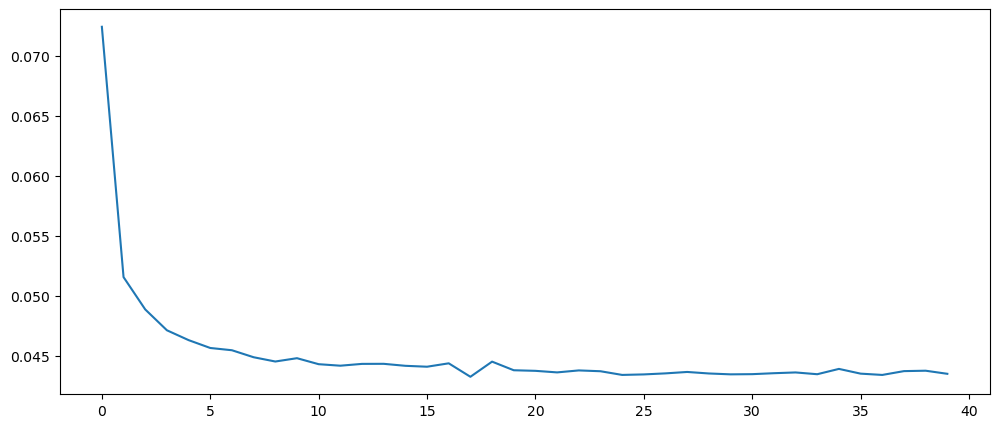

In [1294]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

### Evaluate on Test Data

In [1295]:
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[2.78122688e-01],
       [3.75929389e-01],
       [5.85144738e-01],
       [7.65831401e-01],
       [4.72405205e-01],
       [2.27810607e-01],
       [8.97598923e-05],
       [5.69227317e-02],
       [6.49265437e-01],
       [4.66048321e-01],
       [1.23030892e-01],
       [8.52718977e-04]])

In [1296]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [1297]:
model.predict(first_eval_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


array([[[0.29575002],
        [0.32351023],
        [0.33302388],
        [0.33198398],
        [0.33320957],
        [0.33232388],
        [0.3294516 ],
        [0.32513678],
        [0.32028592],
        [0.32287258],
        [0.32329363],
        [0.32100368]]], dtype=float32)

In [1298]:
scaled_test[0]

array([0.26416336])

In [1299]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [1300]:
current_batch.shape

(1, 12, 1)

In [1301]:
current_batch

array([[[2.78122688e-01],
        [3.75929389e-01],
        [5.85144738e-01],
        [7.65831401e-01],
        [4.72405205e-01],
        [2.27810607e-01],
        [8.97598923e-05],
        [5.69227317e-02],
        [6.49265437e-01],
        [4.66048321e-01],
        [1.23030892e-01],
        [8.52718977e-04]]])

In [1302]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[3.75929389e-01],
        [5.85144738e-01],
        [7.65831401e-01],
        [4.72405205e-01],
        [2.27810607e-01],
        [8.97598923e-05],
        [5.69227317e-02],
        [6.49265437e-01],
        [4.66048321e-01],
        [1.23030892e-01],
        [8.52718977e-04],
        [9.90000000e+01]]])

In [1303]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0,0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [1304]:
test_predictions

[array([0.29575002], dtype=float32),
 array([0.29996985], dtype=float32),
 array([0.3095769], dtype=float32),
 array([0.3123089], dtype=float32),
 array([0.3041595], dtype=float32),
 array([0.29359075], dtype=float32),
 array([0.28760672], dtype=float32),
 array([0.28869182], dtype=float32),
 array([0.3108091], dtype=float32),
 array([0.30388263], dtype=float32),
 array([0.28996617], dtype=float32),
 array([0.2876212], dtype=float32)]

In [1305]:
scaled_test

array([[2.64163363e-01],
       [9.01120613e-01],
       [7.63228364e-01],
       [5.34594958e-01],
       [6.48186102e-01],
       [3.46151822e-01],
       [5.87478495e-01],
       [2.35978757e-01],
       [2.33570200e-01],
       [3.43525514e-04],
       [3.78936345e-01],
       [1.61567806e-03]])

### Inverse Transformations and Compare

In [1306]:
true_predictions = scaler.inverse_transform(test_predictions)

In [1307]:
true_predictions

array([[712.19322201],
       [722.26731268],
       [745.20242147],
       [751.72460437],
       [732.2693307 ],
       [707.03835604],
       [692.75253362],
       [695.34302221],
       [748.14409522],
       [731.60836836],
       [698.38529884],
       [692.78711142]])

In [1308]:
test

machines  Predictions
timestamp                                    
2023-06-01 17:49:00   636.785714   706.802074
2023-06-01 17:50:00  2157.407407   719.915098
2023-06-01 17:51:00  1828.214286   740.090244
2023-06-01 17:52:00  1282.392857   741.770398
2023-06-01 17:53:00  1553.571429   732.080007
2023-06-01 17:54:00   832.518519   698.677716
2023-06-01 17:55:00  1408.642857   684.493919
2023-06-01 17:56:00   569.500000   687.583011
2023-06-01 17:57:00   563.750000   741.601279
2023-06-01 17:58:00     6.962963   731.278741
2023-06-01 17:59:00   910.785714   691.169497
2023-06-01 18:00:00    10.000000   684.535399

In [1309]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

In [1310]:
test

machines  Predictions
timestamp                                    
2023-06-01 17:49:00   636.785714   712.193222
2023-06-01 17:50:00  2157.407407   722.267313
2023-06-01 17:51:00  1828.214286   745.202421
2023-06-01 17:52:00  1282.392857   751.724604
2023-06-01 17:53:00  1553.571429   732.269331
2023-06-01 17:54:00   832.518519   707.038356
2023-06-01 17:55:00  1408.642857   692.752534
2023-06-01 17:56:00   569.500000   695.343022
2023-06-01 17:57:00   563.750000   748.144095
2023-06-01 17:58:00     6.962963   731.608368
2023-06-01 17:59:00   910.785714   698.385299
2023-06-01 18:00:00    10.000000   692.787111

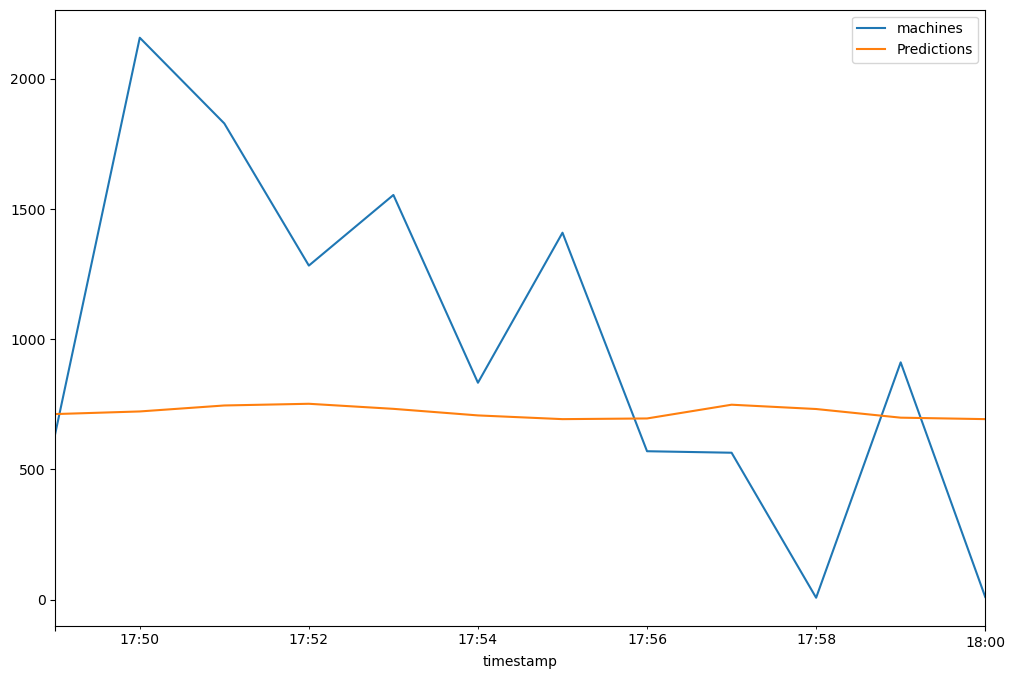

In [1312]:
test.plot(figsize=(12,8))
plt.show()